# Geospatial Data: USGS 3DEP, NLCD, FEMA NFHL, TIGER/Line

This notebook pulls geospatial data from four federal APIs and maps them across the US:

1. **USGS 3DEP** -- Ground elevation & terrain variance (Elevation Point Query Service)
2. **USGS NLCD** -- National Land Cover Database classification (MRLC WMS)
3. **FEMA NFHL** -- Flood hazard zones (ArcGIS REST)
4. **Census TIGER/Line** -- Distance to nearest primary highway (TIGERweb REST)

All APIs are **free, public, and require no authentication**.

Results are saved to CSV and merged with the Census ACS demographic data from notebook 06.

In [4]:
import os
import json
import time
import math
import requests
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter

# Project root
_cwd = os.getcwd()
_project_root = _cwd if os.path.isdir(os.path.join(_cwd, "data")) or os.path.isfile(os.path.join(_cwd, ".env")) else os.path.dirname(_cwd)
DATA_DIR = os.path.join(_project_root, "data")
os.makedirs(DATA_DIR, exist_ok=True)

# Load data sources from config (no hardcoding)
_config_path = os.path.join(_project_root, "configs", "data_sources.yaml")
SOURCES = {}
if os.path.isfile(_config_path):
    try:
        import yaml
        with open(_config_path) as _f:
            SOURCES = yaml.safe_load(_f) or {}
    except Exception:
        pass

print(f"Project root: {_project_root}")
print(f"Data directory: {DATA_DIR}")

Project root: C:\Users\hp\Desktop\Personal_Projects\pj_feb
Data directory: C:\Users\hp\Desktop\Personal_Projects\pj_feb\data


In [2]:
# ---- State centroids (not calculated here; from Census or fallback) ----
# Reliable source: US Census Centers of Population 2020 (mean center of population per state).
# https://www.census.gov/geographies/reference-files/time-series/geo/centers-population.html
CENPOP_URL = "https://www2.census.gov/geo/docs/reference/cenpop2020/CenPop2020_Mean_ST.txt"
_centroids_fallback = {
    "AL": (32.806671, -86.791130), "AK": (61.370716, -152.404419),
    "AZ": (33.729759, -111.431221), "AR": (34.969704, -92.373123),
    "CA": (36.116203, -119.681564), "CO": (39.059811, -105.311104),
    "CT": (41.597782, -72.755371), "DE": (39.318523, -75.507141),
    "DC": (38.897438, -77.026817), "FL": (27.766279, -81.686783),
    "GA": (33.040619, -83.643074), "HI": (21.094318, -157.498337),
    "ID": (44.240459, -114.478828), "IL": (40.349457, -88.986137),
    "IN": (39.849426, -86.258278), "IA": (42.011539, -93.210526),
    "KS": (38.526600, -96.726486), "KY": (37.668140, -84.670067),
    "LA": (31.169546, -91.867805), "ME": (44.693947, -69.381927),
    "MD": (39.063946, -76.802101), "MA": (42.230171, -71.530106),
    "MI": (43.326618, -84.536095), "MN": (45.694454, -93.900192),
    "MS": (32.741646, -89.678696), "MO": (38.456085, -92.288368),
    "MT": (46.921925, -110.454353), "NE": (41.125370, -98.268082),
    "NV": (38.313515, -117.055374), "NH": (43.452492, -71.563896),
    "NJ": (40.298904, -74.521011), "NM": (34.840515, -106.248482),
    "NY": (42.165726, -74.948051), "NC": (35.630066, -79.806419),
    "ND": (47.528912, -99.784012), "OH": (40.388783, -82.764915),
    "OK": (35.565342, -96.928917), "OR": (44.572021, -122.070938),
    "PA": (40.590752, -77.209755), "RI": (41.680893, -71.511780),
    "SC": (33.856892, -80.945007), "SD": (44.299782, -99.438828),
    "TN": (35.747845, -86.692345), "TX": (31.054487, -97.563461),
    "UT": (40.150032, -111.862434), "VT": (44.045876, -72.710686),
    "VA": (37.769337, -78.169968), "WA": (47.400902, -121.490494),
    "WV": (38.491226, -80.954453), "WI": (44.268543, -89.616508),
    "WY": (42.755966, -107.302490),
}

# FIPS to state abbreviation (needed for Census lookup)
FIPS_TO_ABBR = {
    "01": "AL", "02": "AK", "04": "AZ", "05": "AR", "06": "CA",
    "08": "CO", "09": "CT", "10": "DE", "11": "DC", "12": "FL",
    "13": "GA", "15": "HI", "16": "ID", "17": "IL", "18": "IN",
    "19": "IA", "20": "KS", "21": "KY", "22": "LA", "23": "ME",
    "24": "MD", "25": "MA", "26": "MI", "27": "MN", "28": "MS",
    "29": "MO", "30": "MT", "31": "NE", "32": "NV", "33": "NH",
    "34": "NJ", "35": "NM", "36": "NY", "37": "NC", "38": "ND",
    "39": "OH", "40": "OK", "41": "OR", "42": "PA", "44": "RI",
    "45": "SC", "46": "SD", "47": "TN", "48": "TX", "49": "UT",
    "50": "VT", "51": "VA", "53": "WA", "54": "WV", "55": "WI",
    "56": "WY", "72": "PR",
}
STATE_CENTROIDS = {}
try:
    _r = requests.get(CENPOP_URL, timeout=15)
    _r.raise_for_status()
    _lines = _r.text.strip().split("\n")
    for _line in _lines[1:]:
        _p = [_x.strip() for _x in _line.split(",")]
        if len(_p) >= 5:
            _fips, _lat_s, _lon_s = _p[0], _p[3], _p[4]
            _abbr = FIPS_TO_ABBR.get(_fips)
            if _abbr and _abbr != "PR":
                _lat = float(_lat_s.replace("+", ""))
                _lon = float(_lon_s.replace("+", "").replace("-0", "-"))
                STATE_CENTROIDS[_abbr] = (_lat, _lon)
    if not STATE_CENTROIDS:
        STATE_CENTROIDS = _centroids_fallback.copy()
    else:
        print("STATE_CENTROIDS from US Census Centers of Population (2020).")
except Exception as _e:
    STATE_CENTROIDS = _centroids_fallback.copy()
    print(f"STATE_CENTROIDS: fallback (Census unavailable: {_e}).")

# NLCD land cover legend
NLCD_LEGEND = {
    11: "Open Water", 12: "Perennial Ice/Snow",
    21: "Developed, Open Space", 22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity", 24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest", 42: "Evergreen Forest", 43: "Mixed Forest",
    51: "Dwarf Scrub", 52: "Shrub/Scrub",
    71: "Grassland/Herbaceous", 72: "Sedge/Herbaceous", 73: "Lichens", 74: "Moss",
    81: "Pasture/Hay", 82: "Cultivated Crops",
    90: "Woody Wetlands", 95: "Emergent Herbaceous Wetlands",
}

ABBR_TO_FIPS = {v: k for k, v in FIPS_TO_ABBR.items()}

def haversine(lat1, lon1, lat2, lon2):
    """Haversine distance in km between two lat/lon points."""
    R = 6371.0
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

print(f"Defined {len(STATE_CENTROIDS)} state centroids")
print(f"NLCD legend: {len(NLCD_LEGEND)} land cover classes")
print(f"Sample -- Alabama centroid: {STATE_CENTROIDS['AL']}")

Defined 51 state centroids
NLCD legend: 20 land cover classes
Sample -- Alabama centroid: (32.806671, -86.79113)


### State centroids: reliable source (detailed)

**What we use:** One point per state (lat, lon) to query USGS 3DEP, NLCD, FEMA NFHL, and TIGER. Those points are **not calculated** in this notebook; they come from an official source when possible.

**US Census Bureau – Centers of Population**

- **Definition:** For each state, the Census Bureau publishes the **mean center of population**: the balance point if you put one unit of weight at each person’s location (from the decennial census). So it’s the “center of where people live,” not the center of the state’s land area.
- **Why it’s reliable:** Official, documented methodology; updated each decade (we use 2020). Same concept as the national “center of population” that moves each census.
- **Data:** Text file with one row per state: FIPS code, state name, population, latitude, longitude.  
  URL: `https://www2.census.gov/geo/docs/reference/cenpop2020/CenPop2020_Mean_ST.txt`  
  Page: [Census Centers of Population](https://www.census.gov/geographies/reference-files/time-series/geo/centers-population.html)

**Not the same as: geometric centroid**

- **Geometric centroid** = center of the state boundary polygon (like the “middle” of the state’s shape). To get that you would need Census TIGER state boundary shapefiles and compute `.centroid` (or equivalent) for each polygon.
- For this notebook’s goal—one representative point per state to hit 3DEP, NLCD, FEMA, TIGER—**Census centers of population are a solid choice**: they’re official, stable, and usually lie in populated areas where flood/elevation/land cover data exist. If Census is unavailable, the notebook falls back to a pre-defined approximate geographic center for each state.

---
## 1b. API connectivity check (run once to verify all four services)

Before pulling data for all states, this cell tests each API with a single point (CA centroid). **USGS 3DEP**, **USGS NLCD**, and **Census TIGER** should report PASS. **FEMA NFHL** may occasionally report SSL/connection errors from the host; the notebook will still run and FEMA rows will show "ERROR" or "NO DATA" where the request failed.

In [5]:
# ---- Quick API check: one point per service ----
_TEST_LAT, _TEST_LON = 36.116203, -119.681564  # CA centroid

print("1. USGS 3DEP (elevation)")
try:
    r = requests.get("https://epqs.nationalmap.gov/v1/json",
                     params={"x": _TEST_LON, "y": _TEST_LAT, "wkid": 4326, "units": "Feet", "includeDate": "false"}, timeout=15)
    r.raise_for_status()
    v = r.json().get("value")
    print(f"   PASS: elevation = {v} ft" if v is not None and v != -1000000 else "   WARN: no value")
except Exception as e:
    print(f"   FAIL: {e}")

print("2. USGS NLCD (land cover)")
try:
    d = 0.005
    r = requests.get("https://www.mrlc.gov/geoserver/mrlc_display/wms",
                     params={"SERVICE": "WMS", "VERSION": "1.1.1", "REQUEST": "GetFeatureInfo",
                             "LAYERS": "NLCD_2021_Land_Cover_L48", "QUERY_LAYERS": "NLCD_2021_Land_Cover_L48",
                             "INFO_FORMAT": "application/json", "SRS": "EPSG:4326",
                             "BBOX": f"{_TEST_LON-d},{_TEST_LAT-d},{_TEST_LON+d},{_TEST_LAT+d}", "WIDTH": 3, "HEIGHT": 3, "X": 1, "Y": 1}, timeout=15)
    r.raise_for_status()
    fs = r.json().get("features", [])
    code = fs[0].get("properties", {}).get("PALETTE_INDEX") if fs else None
    print(f"   PASS: PALETTE_INDEX = {code}" if code is not None else "   WARN: no features")
except Exception as e:
    print(f"   FAIL: {e}")

print("3. FEMA NFHL (flood zone)")
try:
    r = requests.get("https://hazards.fema.gov/arcgis/rest/services/public/NFHL/MapServer/28/query",
                     params={"geometry": f"{_TEST_LON},{_TEST_LAT}", "geometryType": "esriGeometryPoint",
                             "spatialRel": "esriSpatialRelIntersects", "outFields": "FLD_ZONE,ZONE_SUBTY,SFHA_TF",
                             "returnGeometry": "false", "f": "json", "inSR": 4326}, timeout=20)
    r.raise_for_status()
    data = r.json()
    print("   PASS" if not data.get("error") else f"   FAIL: {data.get('error')}")
except Exception as e:
    print(f"   FAIL (may be SSL/timeout): {e}")

print("4. Census TIGER (highways)")
try:
    env = f"{_TEST_LON-0.3},{_TEST_LAT-0.3},{_TEST_LON+0.3},{_TEST_LAT+0.3}"
    r = requests.get("https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation/MapServer/2/query",
                     params={"geometry": env, "geometryType": "esriGeometryEnvelope",
                             "spatialRel": "esriSpatialRelEnvelopeIntersects", "outFields": "NAME,MTFCC",
                             "returnGeometry": "true", "f": "json", "inSR": 4326, "outSR": 4326, "resultRecordCount": 5}, timeout=30)
    r.raise_for_status()
    data = r.json()
    n = len(data.get("features", []))
    print(f"   PASS: {n} features" if not data.get("error") else f"   FAIL: {data.get('error')}")
except Exception as e:
    print(f"   FAIL: {e}")

print("Done. Proceed to Section 2 if USGS 3DEP and NLCD show PASS.")

1. USGS 3DEP (elevation)
   PASS: elevation = 177.63841751841866 ft
2. USGS NLCD (land cover)
   PASS: PALETTE_INDEX = 82
3. FEMA NFHL (flood zone)
   FAIL (may be SSL/timeout): HTTPSConnectionPool(host='hazards.fema.gov', port=443): Max retries exceeded with url: /arcgis/rest/services/public/NFHL/MapServer/28/query?geometry=-119.681564%2C36.116203&geometryType=esriGeometryPoint&spatialRel=esriSpatialRelIntersects&outFields=FLD_ZONE%2CZONE_SUBTY%2CSFHA_TF&returnGeometry=false&f=json&inSR=4326 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
4. Census TIGER (highways)
   PASS: 5 features
Done. Proceed to Section 2 if USGS 3DEP and NLCD show PASS.


---
## 2. USGS 3DEP -- Ground Elevation & Terrain Variance

The **Elevation Point Query Service (EPQS)** returns elevation in feet for any lat/lon coordinate.

- **Endpoint:** `https://epqs.nationalmap.gov/v1/json`
- **Auth:** None
- We query the centroid of each state, plus 8 offset points (~10 km away) to compute **terrain variance**.
- Derive `topography_class`: Flat (<50 ft std), Rolling (50-200), Hilly (200-500), Mountainous (>500).

In [6]:
# ---- USGS 3DEP: Fetch elevation for all state centroids + terrain variance ----
EPQS_URL = "https://epqs.nationalmap.gov/v1/json"

def get_elevation_ft(lat, lon, retries=3):
    """Query USGS EPQS for elevation in feet. Returns None on failure."""
    for attempt in range(retries):
        try:
            r = requests.get(EPQS_URL, params={
                "x": lon, "y": lat, "wkid": 4326, "units": "Feet", "includeDate": "false"
            }, timeout=15)
            r.raise_for_status()
            data = r.json()
            val = data.get("value")
            if val is not None and val != -1000000:
                return float(val)
            return None
        except Exception:
            if attempt < retries - 1:
                time.sleep(1)
    return None

# ~10 km offsets in degrees (approx 0.09 deg lat, 0.11 deg lon at mid-latitudes)
OFFSETS = [
    (0.09, 0), (-0.09, 0), (0, 0.11), (0, -0.11),   # N, S, E, W
    (0.064, 0.078), (0.064, -0.078), (-0.064, 0.078), (-0.064, -0.078),  # diagonals
]

elevation_results = []
print(f"Fetching elevation for {len(STATE_CENTROIDS)} state centroids (+ 8 offsets each for terrain variance)...")
print("This queries ~468 elevation points total -- may take 2-4 minutes.\n")

for i, (abbr, (lat, lon)) in enumerate(STATE_CENTROIDS.items()):
    # Center elevation
    elev_center = get_elevation_ft(lat, lon)
    
    # 8 surrounding points for terrain variance
    elev_offsets = []
    for dlat, dlon in OFFSETS:
        e = get_elevation_ft(lat + dlat, lon + dlon)
        if e is not None:
            elev_offsets.append(e)
        time.sleep(0.15)
    
    # Compute variance from all sampled points
    all_elevs = ([elev_center] if elev_center is not None else []) + elev_offsets
    elev_variance = float(np.std(all_elevs)) if len(all_elevs) >= 3 else None
    
    # Topography class
    if elev_variance is not None:
        if elev_variance < 50:
            topo_class = "Flat"
        elif elev_variance < 200:
            topo_class = "Rolling"
        elif elev_variance < 500:
            topo_class = "Hilly"
        else:
            topo_class = "Mountainous"
    else:
        topo_class = "Unknown"
    
    elevation_results.append({
        "state_abbr": abbr,
        "lat": lat,
        "lon": lon,
        "ground_elevation_ft": elev_center,
        "terrain_elevation_variance_ft": round(elev_variance, 1) if elev_variance else None,
        "topography_class": topo_class,
        "sample_points": len(all_elevs),
    })
    status = f"{elev_center:,.0f} ft" if elev_center else "N/A"
    var_str = f"var={elev_variance:.0f}" if elev_variance else "var=N/A"
    print(f"  {abbr}: {status}, {var_str}, {topo_class}")
    time.sleep(0.1)

df_elevation = pd.DataFrame(elevation_results)
print(f"\n--- USGS 3DEP Elevation: {len(df_elevation)} states ---")
print(f"Elevation range: {df_elevation['ground_elevation_ft'].min():,.0f} - {df_elevation['ground_elevation_ft'].max():,.0f} ft")
print(f"Topography classes: {df_elevation['topography_class'].value_counts().to_dict()}")
df_elevation.head(10)

Fetching elevation for 51 state centroids (+ 8 offsets each for terrain variance)...
This queries ~468 elevation points total -- may take 2-4 minutes.

  AL: 386 ft, var=92, Rolling
  AK: 8,266 ft, var=1805, Mountainous
  AZ: 3,828 ft, var=1016, Mountainous
  AR: 278 ft, var=37, Flat
  CA: 178 ft, var=8, Flat
  CO: 8,602 ft, var=776, Mountainous
  CT: 175 ft, var=145, Rolling
  DE: 5 ft, var=16, Flat
  DC: 31 ft, var=127, Rolling
  FL: 138 ft, var=25, Flat
  GA: 591 ft, var=92, Rolling
  HI: N/A, var=N/A, Unknown
  ID: 5,762 ft, var=726, Mountainous
  IL: 787 ft, var=61, Rolling
  IN: 804 ft, var=65, Rolling
  IA: 1,105 ft, var=42, Flat
  KS: 1,307 ft, var=74, Rolling
  KY: 907 ft, var=65, Rolling
  LA: 44 ft, var=8, Flat
  ME: 209 ft, var=58, Rolling
  MD: 108 ft, var=76, Rolling
  MA: 408 ft, var=104, Rolling
  MI: 728 ft, var=19, Flat
  MN: 1,163 ft, var=56, Rolling
  MS: 321 ft, var=28, Flat
  MO: 729 ft, var=76, Rolling
  MT: 6,148 ft, var=738, Mountainous
  NE: 1,819 ft, var=37, 

,state_abbr,lat,lon,ground_elevation_ft,terrain_elevation_variance_ft,topography_class,sample_points
0,AL,32.806671,-86.791130,386.477005,91.5,Rolling,9
1,AK,61.370716,-152.404419,8266.109220,1804.7,Mountainous,9
2,AZ,33.729759,-111.431221,3827.543606,1015.6,Mountainous,9
3,AR,34.969704,-92.373123,277.777553,36.9,Flat,9
4,CA,36.116203,-119.681564,177.638418,8.1,Flat,9
5,CO,39.059811,-105.311104,8601.686448,776.3,Mountainous,9
6,CT,41.597782,-72.755371,174.799810,145.2,Rolling,9
7,DE,39.318523,-75.507141,5.063338,16.4,Flat,9
8,DC,38.897438,-77.026817,30.665142,127.5,Rolling,9
9,FL,27.766279,-81.686783,137.714218,24.7,Flat,9


In [ ]:
# ---- Save elevation data ----
elev_path = os.path.join(DATA_DIR, "usgs_elevation_by_state.csv")
df_elevation.to_csv(elev_path, index=False)
print(f"Saved: {elev_path}")
print(f"  Rows: {len(df_elevation)} | Columns: {len(df_elevation.columns)}")

In [ ]:
# ---- Map 1: Ground Elevation by State ----
fig_elev = px.choropleth(
    df_elevation,
    locations="state_abbr",
    locationmode="USA-states",
    color="ground_elevation_ft",
    scope="usa",
    color_continuous_scale="Earth",
    hover_name="state_abbr",
    hover_data={
        "ground_elevation_ft": ":,.0f",
        "terrain_elevation_variance_ft": ":,.0f",
        "topography_class": True,
        "state_abbr": False,
    },
    labels={"ground_elevation_ft": "Elevation (ft)"},
    title="USGS 3DEP -- Ground Elevation at State Centroid (feet)",
)
fig_elev.update_layout(
    geo=dict(bgcolor="rgba(0,0,0,0)"),
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=50, b=0),
    height=500,
)
fig_elev.show()

In [ ]:
# ---- Map 2: Terrain Variance & Topography Class by State ----
topo_order = ["Flat", "Rolling", "Hilly", "Mountainous", "Unknown"]
topo_colors = {"Flat": "#2ecc71", "Rolling": "#f39c12", "Hilly": "#e74c3c", "Mountainous": "#8e44ad", "Unknown": "#bdc3c7"}

fig_topo = px.choropleth(
    df_elevation,
    locations="state_abbr",
    locationmode="USA-states",
    color="topography_class",
    scope="usa",
    category_orders={"topography_class": topo_order},
    color_discrete_map=topo_colors,
    hover_name="state_abbr",
    hover_data={
        "ground_elevation_ft": ":,.0f",
        "terrain_elevation_variance_ft": ":,.0f",
        "topography_class": True,
        "state_abbr": False,
    },
    labels={"topography_class": "Topography"},
    title="USGS 3DEP -- Topography Class by State (based on ~10 km terrain variance)",
)
fig_topo.update_layout(
    geo=dict(bgcolor="rgba(0,0,0,0)"),
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=50, b=0),
    height=500,
)
fig_topo.show()

---
## 3. USGS NLCD -- National Land Cover Database

The **MRLC WMS** service returns NLCD land cover classification codes at any coordinate.

- **Endpoint:** `https://www.mrlc.gov/geoserver/mrlc_display/wms` (GetFeatureInfo)
- **Auth:** None
- Returns `PALETTE_INDEX` which maps to NLCD class codes (e.g., 42 = Evergreen Forest).
- We query 5 points per state (center + 4 offsets) and take the **mode** for dominant land cover.

In [7]:
# ---- USGS NLCD: Fetch land cover for all state centroids ----
MRLC_WMS_URL = "https://www.mrlc.gov/geoserver/mrlc_display/wms"

def get_nlcd_code(lat, lon, retries=2):
    """Query MRLC WMS GetFeatureInfo for NLCD land cover code at a point."""
    delta = 0.005  # small bbox around point
    params = {
        "SERVICE": "WMS",
        "VERSION": "1.1.1",
        "REQUEST": "GetFeatureInfo",
        "LAYERS": "NLCD_2021_Land_Cover_L48",
        "QUERY_LAYERS": "NLCD_2021_Land_Cover_L48",
        "INFO_FORMAT": "application/json",
        "SRS": "EPSG:4326",
        "BBOX": f"{lon - delta},{lat - delta},{lon + delta},{lat + delta}",
        "WIDTH": 3,
        "HEIGHT": 3,
        "X": 1,
        "Y": 1,
    }
    for attempt in range(retries):
        try:
            r = requests.get(MRLC_WMS_URL, params=params, timeout=15)
            r.raise_for_status()
            data = r.json()
            features = data.get("features", [])
            if features:
                code = features[0].get("properties", {}).get("PALETTE_INDEX")
                if code is not None:
                    return int(code)
            return None
        except Exception:
            if attempt < retries - 1:
                time.sleep(1)
    return None

# Offsets for 4 additional sample points (~15 km in each cardinal direction)
NLCD_OFFSETS = [(0.14, 0), (-0.14, 0), (0, 0.17), (0, -0.17)]

nlcd_results = []
print(f"Fetching NLCD land cover for {len(STATE_CENTROIDS)} state centroids (5 samples each)...")
print("Note: Alaska & Hawaii may not have NLCD_2021_Land_Cover_L48 coverage.\n")

for abbr, (lat, lon) in STATE_CENTROIDS.items():
    # Center point
    codes = []
    center_code = get_nlcd_code(lat, lon)
    if center_code is not None:
        codes.append(center_code)
    
    # 4 offsets
    for dlat, dlon in NLCD_OFFSETS:
        c = get_nlcd_code(lat + dlat, lon + dlon)
        if c is not None:
            codes.append(c)
        time.sleep(0.2)
    
    # Dominant class = mode
    if codes:
        dominant_code = Counter(codes).most_common(1)[0][0]
        dominant_label = NLCD_LEGEND.get(dominant_code, f"Unknown ({dominant_code})")
    else:
        dominant_code = None
        dominant_label = "No Data"
    
    nlcd_results.append({
        "state_abbr": abbr,
        "nlcd_center_code": center_code,
        "nlcd_center_label": NLCD_LEGEND.get(center_code, "No Data") if center_code else "No Data",
        "nlcd_dominant_code": dominant_code,
        "nlcd_dominant_label": dominant_label,
        "nlcd_samples": len(codes),
    })
    print(f"  {abbr}: {dominant_label} (code={dominant_code}, {len(codes)} samples)")
    time.sleep(0.1)

df_nlcd = pd.DataFrame(nlcd_results)
print(f"\n--- USGS NLCD Land Cover: {len(df_nlcd)} states ---")
print(f"Dominant land cover distribution:")
print(df_nlcd["nlcd_dominant_label"].value_counts().to_string())
df_nlcd.head(10)

Fetching NLCD land cover for 51 state centroids (5 samples each)...
Note: Alaska & Hawaii may not have NLCD_2021_Land_Cover_L48 coverage.

  AL: Evergreen Forest (code=42, 5 samples)
  AK: No Data (code=None, 0 samples)
  AZ: Grassland/Herbaceous (code=71, 5 samples)
  AR: Pasture/Hay (code=81, 5 samples)
  CA: Cultivated Crops (code=82, 5 samples)
  CO: Evergreen Forest (code=42, 5 samples)
  CT: Deciduous Forest (code=41, 5 samples)
  DE: Deciduous Forest (code=41, 5 samples)
  DC: Developed, Low Intensity (code=22, 5 samples)
  FL: Woody Wetlands (code=90, 5 samples)
  GA: Evergreen Forest (code=42, 5 samples)
  HI: No Data (code=None, 0 samples)
  ID: Evergreen Forest (code=42, 5 samples)
  IL: Cultivated Crops (code=82, 5 samples)
  IN: Developed, Open Space (code=21, 5 samples)
  IA: Cultivated Crops (code=82, 5 samples)
  KS: Grassland/Herbaceous (code=71, 5 samples)
  KY: Pasture/Hay (code=81, 5 samples)
  LA: Woody Wetlands (code=90, 5 samples)
  ME: Deciduous Forest (code=41,

,state_abbr,nlcd_center_code,nlcd_center_label,nlcd_dominant_code,nlcd_dominant_label,nlcd_samples
0,AL,41.0,Deciduous Forest,42.0,Evergreen Forest,5
1,AK,NaN,No Data,NaN,No Data,0
2,AZ,71.0,Grassland/Herbaceous,71.0,Grassland/Herbaceous,5
3,AR,81.0,Pasture/Hay,81.0,Pasture/Hay,5
4,CA,82.0,Cultivated Crops,82.0,Cultivated Crops,5
5,CO,42.0,Evergreen Forest,42.0,Evergreen Forest,5
6,CT,41.0,Deciduous Forest,41.0,Deciduous Forest,5
7,DE,41.0,Deciduous Forest,41.0,Deciduous Forest,5
8,DC,24.0,"Developed, High Intensity",22.0,"Developed, Low Intensity",5
9,FL,90.0,Woody Wetlands,90.0,Woody Wetlands,5


In [8]:
# ---- Save NLCD data ----
nlcd_path = os.path.join(DATA_DIR, "usgs_nlcd_landcover_by_state.csv")
df_nlcd.to_csv(nlcd_path, index=False)
print(f"Saved: {nlcd_path}")
print(f"  Rows: {len(df_nlcd)} | Columns: {len(df_nlcd.columns)}")

Saved: C:\Users\hp\Desktop\Personal_Projects\pj_feb\data\usgs_nlcd_landcover_by_state.csv
  Rows: 51 | Columns: 6


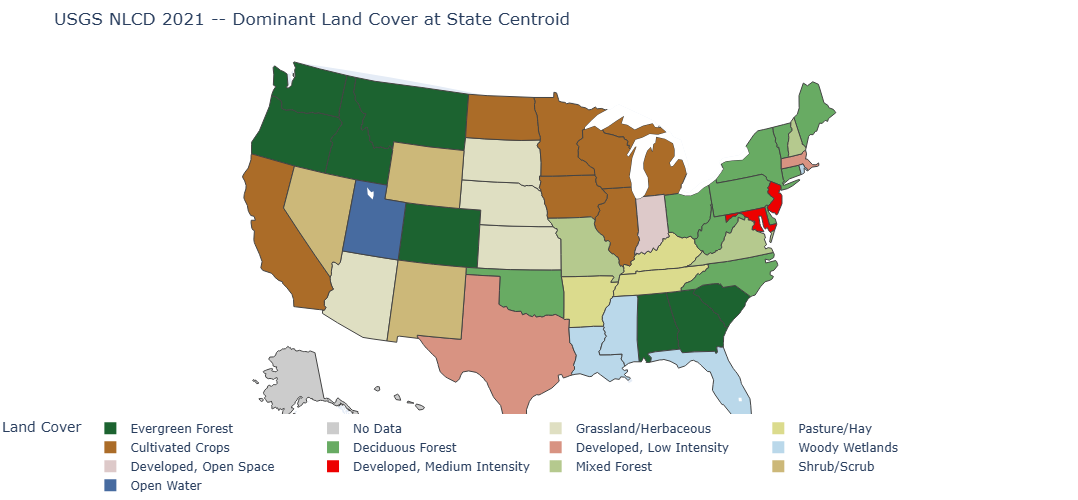

In [9]:
# ---- Map 3: NLCD Dominant Land Cover by State ----
# Assign a color to each land cover type
lc_colors = {
    "Open Water": "#476ba0", "Perennial Ice/Snow": "#d1def8",
    "Developed, Open Space": "#ddc9c9", "Developed, Low Intensity": "#d89382",
    "Developed, Medium Intensity": "#ed0000", "Developed, High Intensity": "#aa0000",
    "Barren Land": "#b2ada3",
    "Deciduous Forest": "#68ab63", "Evergreen Forest": "#1c6330", "Mixed Forest": "#b5c98e",
    "Dwarf Scrub": "#a58c30", "Shrub/Scrub": "#ccb879",
    "Grassland/Herbaceous": "#dfdfc2", "Sedge/Herbaceous": "#d1d182",
    "Pasture/Hay": "#dbdb8d", "Cultivated Crops": "#ab6c28",
    "Woody Wetlands": "#bad8ea", "Emergent Herbaceous Wetlands": "#70a3ba",
    "No Data": "#cccccc",
}

fig_nlcd = px.choropleth(
    df_nlcd,
    locations="state_abbr",
    locationmode="USA-states",
    color="nlcd_dominant_label",
    scope="usa",
    color_discrete_map=lc_colors,
    hover_name="state_abbr",
    hover_data={
        "nlcd_dominant_label": True,
        "nlcd_dominant_code": True,
        "nlcd_samples": True,
        "state_abbr": False,
    },
    labels={"nlcd_dominant_label": "Land Cover"},
    title="USGS NLCD 2021 -- Dominant Land Cover at State Centroid",
)
fig_nlcd.update_layout(
    geo=dict(bgcolor="rgba(0,0,0,0)"),
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=50, b=0),
    height=500,
    legend=dict(title="Land Cover", orientation="h", yanchor="bottom", y=-0.15),
)
fig_nlcd.show()

---
## 4. FEMA NFHL -- Flood Hazard Zones

The **FEMA National Flood Hazard Layer** provides flood zone classification via ArcGIS REST.

- **Endpoint:** `https://hazards.fema.gov/arcgis/rest/services/public/NFHL/MapServer/28/query`
- **Auth:** None
- Returns `FLD_ZONE` (A, AE, V, VE, X, etc.), `ZONE_SUBTY`, `SFHA_TF` (Special Flood Hazard Area).
- Derive `flood_risk_score`: High-risk (A/V zones) = 3, Moderate (B/X-500) = 2, Minimal (X/C) = 1.
- **Note:** FEMA's server may occasionally return SSL/connection errors; the notebook continues and marks those rows as ERROR or NO DATA.

In [10]:
# ---- Optional: one live FEMA NFHL API request (run to test connectivity) ----
# FEMA's server sometimes returns SSL/connection errors; this cell tries with a Session + retries.
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

FEMA_QUERY_URL = "https://hazards.fema.gov/arcgis/rest/services/public/NFHL/MapServer/28/query"
test_lon, test_lat = -119.681564, 36.116203  # CA
params = {
    "geometry": f"{test_lon},{test_lat}",
    "geometryType": "esriGeometryPoint",
    "spatialRel": "esriSpatialRelIntersects",
    "outFields": "FLD_ZONE,ZONE_SUBTY,SFHA_TF",
    "returnGeometry": "false",
    "f": "json",
    "inSR": 4326,
}

session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[502, 503, 504])
session.mount("https://", HTTPAdapter(max_retries=retries))

try:
    r = session.get(FEMA_QUERY_URL, params=params, timeout=25)
    r.raise_for_status()
    data = r.json()
    feats = data.get("features", [])
    if feats:
        attrs = feats[0].get("attributes", {})
        print("FEMA live request: PASS")
        print("  FLD_ZONE:", attrs.get("FLD_ZONE"), "| ZONE_SUBTY:", attrs.get("ZONE_SUBTY"), "| SFHA_TF:", attrs.get("SFHA_TF"))
    else:
        print("FEMA live request: PASS (no features at this point — centroid may be outside NFHL coverage)")
except Exception as e:
    print("FEMA live request: FAIL —", type(e).__name__, str(e))
    print("  (Common: SSLError from hazards.fema.gov. Try again later or from a different network.)")

FEMA live request: FAIL — SSLError HTTPSConnectionPool(host='hazards.fema.gov', port=443): Max retries exceeded with url: /arcgis/rest/services/public/NFHL/MapServer/28/query?geometry=-119.681564%2C36.116203&geometryType=esriGeometryPoint&spatialRel=esriSpatialRelIntersects&outFields=FLD_ZONE%2CZONE_SUBTY%2CSFHA_TF&returnGeometry=false&f=json&inSR=4326 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))
  (Common: SSLError from hazards.fema.gov. Try again later or from a different network.)


In [11]:
# ---- FEMA NFHL: Fetch flood zone for all state centroids ----
FEMA_URL = "https://hazards.fema.gov/arcgis/rest/services/public/NFHL/MapServer/28/query"

def get_flood_zone(lat, lon, retries=2):
    """Query FEMA NFHL for flood zone at a point."""
    params = {
        "geometry": f"{lon},{lat}",
        "geometryType": "esriGeometryPoint",
        "spatialRel": "esriSpatialRelIntersects",
        "outFields": "FLD_ZONE,ZONE_SUBTY,SFHA_TF",
        "returnGeometry": "false",
        "f": "json",
        "inSR": 4326,
    }
    for attempt in range(retries):
        try:
            r = requests.get(FEMA_URL, params=params, timeout=20)
            r.raise_for_status()
            data = r.json()
            features = data.get("features", [])
            if features:
                attrs = features[0].get("attributes", {})
                return {
                    "fld_zone": attrs.get("FLD_ZONE", ""),
                    "zone_subtype": attrs.get("ZONE_SUBTY", ""),
                    "sfha_tf": attrs.get("SFHA_TF", ""),
                }
            return {"fld_zone": "NO DATA", "zone_subtype": "No NFHL coverage at centroid", "sfha_tf": ""}
        except Exception as e:
            if attempt < retries - 1:
                time.sleep(1)
    return {"fld_zone": "ERROR", "zone_subtype": str(e), "sfha_tf": ""}

def flood_risk_score(zone):
    """Derive numeric flood risk from FEMA zone code."""
    if not zone or zone in ("ERROR", "NO DATA"):
        return None
    zone_upper = zone.strip().upper()
    # High risk: A zones, V zones (coastal)
    if zone_upper.startswith("A") or zone_upper.startswith("V"):
        return 3
    # Moderate risk: B, X (shaded / 500-year)
    if zone_upper == "B" or "500" in zone_upper:
        return 2
    # Minimal risk: X (unshaded), C, D
    return 1

fema_results = []
print(f"Fetching FEMA flood zones for {len(STATE_CENTROIDS)} state centroids...")
print("Note: Some centroids may fall outside NFHL-mapped areas.\n")

for abbr, (lat, lon) in STATE_CENTROIDS.items():
    result = get_flood_zone(lat, lon)
    score = flood_risk_score(result["fld_zone"])
    fema_results.append({
        "state_abbr": abbr,
        "fema_flood_zone": result["fld_zone"],
        "fema_zone_subtype": result["zone_subtype"],
        "fema_sfha": result["sfha_tf"],
        "flood_risk_score": score,
    })
    risk_label = {1: "Minimal", 2: "Moderate", 3: "High"}.get(score, "N/A")
    print(f"  {abbr}: Zone {result['fld_zone']:6s} | {risk_label:8s} | {result['zone_subtype'][:50]}")
    time.sleep(0.3)

df_fema = pd.DataFrame(fema_results)
print(f"\n--- FEMA Flood Zones: {len(df_fema)} states ---")
print(f"Zone distribution: {df_fema['fema_flood_zone'].value_counts().to_dict()}")
print(f"Risk scores: {df_fema['flood_risk_score'].value_counts().sort_index().to_dict()}")
df_fema.head(10)

Fetching FEMA flood zones for 51 state centroids...
Note: Some centroids may fall outside NFHL-mapped areas.



UnboundLocalError: cannot access local variable 'e' where it is not associated with a value

In [ ]:
# ---- Save FEMA flood zone data ----
fema_path = os.path.join(DATA_DIR, "fema_flood_zones_by_state.csv")
df_fema.to_csv(fema_path, index=False)
print(f"Saved: {fema_path}")
print(f"  Rows: {len(df_fema)} | Columns: {len(df_fema.columns)}")

In [ ]:
# ---- Map 4: FEMA Flood Risk Score by State ----
risk_colors = {1: "#2ecc71", 2: "#f39c12", 3: "#e74c3c"}
risk_labels = {1: "Minimal", 2: "Moderate", 3: "High"}

df_fema_map = df_fema.dropna(subset=["flood_risk_score"]).copy()
df_fema_map["risk_label"] = df_fema_map["flood_risk_score"].map(risk_labels)

fig_fema = px.choropleth(
    df_fema_map,
    locations="state_abbr",
    locationmode="USA-states",
    color="risk_label",
    scope="usa",
    color_discrete_map={"Minimal": "#2ecc71", "Moderate": "#f39c12", "High": "#e74c3c"},
    category_orders={"risk_label": ["Minimal", "Moderate", "High"]},
    hover_name="state_abbr",
    hover_data={
        "fema_flood_zone": True,
        "fema_zone_subtype": True,
        "flood_risk_score": True,
        "risk_label": True,
        "state_abbr": False,
    },
    labels={"risk_label": "Flood Risk"},
    title="FEMA NFHL -- Flood Risk at State Centroid",
)
fig_fema.update_layout(
    geo=dict(bgcolor="rgba(0,0,0,0)"),
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=50, b=0),
    height=500,
)
fig_fema.show()

---
## 5. Census TIGER/Line -- Highway Proximity

**TIGERweb** provides US road geometry. We query Layer 2 (Primary Roads = Interstates & US Highways).

- **Endpoint:** `https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation/MapServer/2/query`
- **Auth:** None
- Query a small bounding box around each state centroid and find the nearest primary road.
- Compute `distance_to_nearest_highway_km` via haversine to nearest road vertex.

In [12]:
# ---- TIGER/Line: Distance to nearest primary highway for each state centroid ----
TIGER_URL = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation/MapServer/2/query"

def get_nearest_highway(lat, lon, bbox_size=0.3, retries=2):
    """
    Query TIGERweb for primary roads within a bounding box around (lat, lon).
    Returns (distance_km, highway_name) or (None, None) on failure.
    """
    envelope = f"{lon - bbox_size},{lat - bbox_size},{lon + bbox_size},{lat + bbox_size}"
    params = {
        "geometry": envelope,
        "geometryType": "esriGeometryEnvelope",
        "spatialRel": "esriSpatialRelEnvelopeIntersects",
        "outFields": "NAME,MTFCC",
        "returnGeometry": "true",
        "f": "json",
        "inSR": 4326,
        "outSR": 4326,
        "resultRecordCount": 50,
    }
    for attempt in range(retries):
        try:
            r = requests.get(TIGER_URL, params=params, timeout=30)
            r.raise_for_status()
            data = r.json()
            features = data.get("features", [])
            if not features:
                return None, None
            
            # Find nearest road vertex to our point
            min_dist = float("inf")
            nearest_name = ""
            for feat in features:
                name = feat.get("attributes", {}).get("NAME", "Unknown")
                geom = feat.get("geometry", {})
                paths = geom.get("paths", [])
                for path in paths:
                    for vertex in path:
                        vlon, vlat = vertex[0], vertex[1]
                        d = haversine(lat, lon, vlat, vlon)
                        if d < min_dist:
                            min_dist = d
                            nearest_name = name
            return round(min_dist, 2), nearest_name
        except Exception:
            if attempt < retries - 1:
                time.sleep(2)
    return None, None

tiger_results = []
print(f"Fetching nearest primary highway for {len(STATE_CENTROIDS)} state centroids...")
print("Using TIGERweb Layer 2 (Primary Roads: Interstates + US Highways).")
print("Note: Queries with large bbox can be slow. Using 0.3 deg (~30 km) initial bbox.\n")

for abbr, (lat, lon) in STATE_CENTROIDS.items():
    dist_km, hwy_name = get_nearest_highway(lat, lon, bbox_size=0.3)
    
    # If no results in small bbox, try larger
    if dist_km is None:
        dist_km, hwy_name = get_nearest_highway(lat, lon, bbox_size=0.6)
    
    tiger_results.append({
        "state_abbr": abbr,
        "distance_to_nearest_highway_km": dist_km,
        "nearest_highway_name": hwy_name if hwy_name else "No data",
    })
    dist_str = f"{dist_km:.1f} km" if dist_km is not None else "N/A"
    name_str = hwy_name[:40] if hwy_name else "N/A"
    print(f"  {abbr}: {dist_str:>10s} | {name_str}")
    time.sleep(0.5)

df_tiger = pd.DataFrame(tiger_results)
print(f"\n--- TIGER Highway Proximity: {len(df_tiger)} states ---")
valid = df_tiger["distance_to_nearest_highway_km"].dropna()
print(f"Distance range: {valid.min():.1f} - {valid.max():.1f} km")
print(f"Mean distance: {valid.mean():.1f} km")
print(f"States with data: {len(valid)}/{len(df_tiger)}")
df_tiger.head(10)

Fetching nearest primary highway for 51 state centroids...
Using TIGERweb Layer 2 (Primary Roads: Interstates + US Highways).
Note: Queries with large bbox can be slow. Using 0.3 deg (~30 km) initial bbox.

  AL:    18.0 km | I- 65
  AK:        N/A | N/A
  AZ:    36.9 km | State Rte 202
  AR:     4.1 km | I- 40
  CA:    20.6 km | State Rte 41
  CO:    38.8 km | I- 25
  CT:     4.2 km | Berlin Tpke
  DE:     7.6 km | State Rd 1
  DC:     2.4 km | Arland D Williams Memorial Brg
  FL:    31.1 km | Polk Pkwy
  GA:    14.8 km | I- 75
  HI:    35.6 km | State Hwy 72
  ID:        N/A | N/A
  IL:     8.3 km | I- 55
  IN:     1.5 km | I- 465
  IA:    29.2 km | US Hwy 30
  KS:    41.5 km | I- 35
  KY:    37.5 km | I- 75
  LA:    45.6 km | I- 49
  ME:     5.6 km | I- 95
  MD:    13.1 km | John Hanson Hwy
  MA:     1.6 km | Blue Star Memorial Hwy
  MI:     5.2 km | US Hwy 27
  MN:    22.1 km | US Hwy 10
  MS:    35.7 km | I- 55
  MO:    11.2 km | US Hwy 54
  MT:        N/A | N/A
  NE:    33.8 km |

,state_abbr,distance_to_nearest_highway_km,nearest_highway_name
0,AL,18.03,I- 65
1,AK,NaN,No data
2,AZ,36.91,State Rte 202
3,AR,4.09,I- 40
4,CA,20.58,State Rte 41
5,CO,38.83,I- 25
6,CT,4.22,Berlin Tpke
7,DE,7.60,State Rd 1
8,DC,2.36,Arland D Williams Memorial Brg
9,FL,31.05,Polk Pkwy


In [ ]:
# ---- Save TIGER highway data ----
tiger_path = os.path.join(DATA_DIR, "tiger_highway_proximity_by_state.csv")
df_tiger.to_csv(tiger_path, index=False)
print(f"Saved: {tiger_path}")
print(f"  Rows: {len(df_tiger)} | Columns: {len(df_tiger.columns)}")

---
## 5b. Distance to Nearest Interstate (TIGER RTTYP='I')

Query TIGER Layer 2 with `where="RTTYP='I'"` for interstates only. URL from config.

In [ ]:
# ---- TIGER: Distance to nearest INTERSTATE (RTTYP='I') ----
tiger_cfg = SOURCES.get("tiger", {})
base = tiger_cfg.get("transportation_base", "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation/MapServer")
layer = tiger_cfg.get("primary_roads_layer", 2)
interstate_filter = tiger_cfg.get("interstates_filter", "RTTYP='I'")
TIGER_INTERSTATE_URL = f"{base}/{layer}/query"

def get_nearest_interstate(lat, lon, bbox_size=0.3, retries=2):
    envelope = f"{lon - bbox_size},{lat - bbox_size},{lon + bbox_size},{lat + bbox_size}"
    params = {
        "where": interstate_filter,
        "geometry": envelope,
        "geometryType": "esriGeometryEnvelope",
        "spatialRel": "esriSpatialRelEnvelopeIntersects",
        "outFields": "NAME,RTTYP",
        "returnGeometry": "true",
        "f": "json", "inSR": 4326, "outSR": 4326,
        "resultRecordCount": 50,
    }
    for attempt in range(retries):
        try:
            r = requests.get(TIGER_INTERSTATE_URL, params=params, timeout=30)
            r.raise_for_status()
            data = r.json()
            features = data.get("features", [])
            if not features:
                return None, None
            min_dist, nearest_name = float("inf"), ""
            for feat in features:
                name = feat.get("attributes", {}).get("NAME", "")
                for path in feat.get("geometry", {}).get("paths", []):
                    for v in path:
                        d = haversine(lat, lon, v[1], v[0])
                        if d < min_dist:
                            min_dist, nearest_name = d, name
            return round(min_dist, 2), nearest_name
        except Exception:
            if attempt < retries - 1:
                time.sleep(2)
    return None, None

tiger_interstate_results = []
print(f"Fetching nearest interstate for {len(STATE_CENTROIDS)} state centroids...")
for abbr, (lat, lon) in STATE_CENTROIDS.items():
    dist, name = get_nearest_interstate(lat, lon)
    if dist is None:
        dist, name = get_nearest_interstate(lat, lon, bbox_size=0.6)
    tiger_interstate_results.append({
        "state_abbr": abbr,
        "distance_to_nearest_interstate_km": dist,
        "nearest_interstate_name": name or "No data",
    })
    print(f"  {abbr}: {dist:.1f} km" if dist else f"  {abbr}: N/A")
    time.sleep(0.5)

df_tiger_interstate = pd.DataFrame(tiger_interstate_results)
valid = df_tiger_interstate["distance_to_nearest_interstate_km"].dropna()
if len(valid) > 0:
    print(f"\n--- Interstate Proximity: {len(valid)} states ---")
    print(f"Range: {valid.min():.1f} - {valid.max():.1f} km")
    interstate_path = os.path.join(DATA_DIR, "tiger_interstate_proximity_by_state.csv")
    df_tiger_interstate.to_csv(interstate_path, index=False)
    print(f"Saved: {interstate_path}")
df_tiger_interstate.head(10)


In [ ]:
# ---- Map 5: Distance to Nearest Highway by State ----
df_tiger_map = df_tiger.dropna(subset=["distance_to_nearest_highway_km"]).copy()

fig_tiger = px.choropleth(
    df_tiger_map,
    locations="state_abbr",
    locationmode="USA-states",
    color="distance_to_nearest_highway_km",
    scope="usa",
    color_continuous_scale="RdYlGn_r",  # red = far, green = close
    hover_name="state_abbr",
    hover_data={
        "distance_to_nearest_highway_km": ":.1f",
        "nearest_highway_name": True,
        "state_abbr": False,
    },
    labels={"distance_to_nearest_highway_km": "Distance (km)"},
    title="Census TIGER/Line -- Distance from State Centroid to Nearest Primary Highway (km)",
)
fig_tiger.update_layout(
    geo=dict(bgcolor="rgba(0,0,0,0)"),
    paper_bgcolor="white",
    margin=dict(l=0, r=0, t=50, b=0),
    height=500,
)
fig_tiger.show()

---
## 6b. FMV Composite Features — Compound Hazard, High-Demand Corridor

Derived from existing geospatial data (no new API calls):

- **Compound hazard**: `flood_risk_score × (terrain_variance_ft / 100)` — flood + rough terrain = stronger risk discount
- **High-demand corridor**: `nlcd_is_developed × (10 - distance_to_highway_km/5)` — developed + near highway = premium

---
## 6b. FMV Composite Features

Compound hazard and high-demand corridor derived from existing geo data.

---
## 6. Combine All Geospatial Data & Merge with Census

Join all 4 geospatial DataFrames on `state_abbr`, then merge with the Census ACS state-level
demographics from notebook 06. The census data has 15 years per state; geo attributes are static
(repeat for each year).

In [ ]:
# ---- Combine all geospatial datasets ----
df_geo = df_elevation[["state_abbr", "lat", "lon", "ground_elevation_ft",
                        "terrain_elevation_variance_ft", "topography_class"]].copy()

# Merge NLCD
df_geo = df_geo.merge(
    df_nlcd[["state_abbr", "nlcd_dominant_code", "nlcd_dominant_label"]],
    on="state_abbr", how="left"
)

# Merge FEMA
df_geo = df_geo.merge(
    df_fema[["state_abbr", "fema_flood_zone", "fema_zone_subtype", "flood_risk_score"]],
    on="state_abbr", how="left"
)

# Merge TIGER
df_geo = df_geo.merge(
    df_tiger[["state_abbr", "distance_to_nearest_highway_km", "nearest_highway_name"]],
    on="state_abbr", how="left"
)

# Merge interstate distance if available
if "df_tiger_interstate" in dir() and len(df_tiger_interstate) > 0:
    df_geo = df_geo.merge(
        df_tiger_interstate[["state_abbr", "distance_to_nearest_interstate_km"]],
        on="state_abbr", how="left"
    )

# FMV composite features (high impact, low effort)
df_geo["nlcd_is_developed"] = df_geo["nlcd_dominant_code"].apply(lambda c: 1 if c and 21 <= c <= 24 else 0)
flood = df_geo["flood_risk_score"].fillna(1).clip(1, 3)
terrain_norm = (df_geo["terrain_elevation_variance_ft"].fillna(0) / 100).clip(0, 10)
df_geo["compound_hazard_score"] = (flood * terrain_norm).clip(0, 10)
hwy_dist = df_geo["distance_to_nearest_highway_km"].fillna(50).clip(0, 50)
df_geo["high_demand_corridor_score"] = df_geo["nlcd_is_developed"] * (10 - hwy_dist / 5).clip(0, 10)

print(f"--- Combined Geospatial Dataset: {len(df_geo)} states x {len(df_geo.columns)} columns ---")
print(f"Columns: {list(df_geo.columns)}")
df_geo.head(10)


In [ ]:
# ---- Merge with Census ACS state-level data ----
# Try loading from CSV first; fall back to in-memory if available
census_path = os.path.join(DATA_DIR, "census_state_demographics_2010_2024.csv")

if os.path.exists(census_path):
    df_census = pd.read_csv(census_path, dtype={"state": str})
    # Add state_abbr if missing
    if "state_abbr" not in df_census.columns:
        df_census["state_abbr"] = df_census["state"].map(FIPS_TO_ABBR)
    print(f"Loaded census data from CSV: {len(df_census)} rows x {len(df_census.columns)} cols")
else:
    print(f"Census CSV not found at {census_path}")
    print("Run notebook 06 first to generate census data, or provide the CSV.")
    df_census = None

if df_census is not None:
    # Merge: census (many years) LEFT JOIN geo (static per state)
    df_combined = df_census.merge(df_geo, on="state_abbr", how="left")
    print(f"\n--- Combined Census + Geo Dataset ---")
    print(f"Rows: {len(df_combined):,} | Columns: {len(df_combined.columns)}")
    print(f"Years: {df_combined['year'].min()} - {df_combined['year'].max()}")
    print(f"\nNew columns added from geo data:")
    geo_cols = [c for c in df_combined.columns if c not in df_census.columns]
    print(f"  {geo_cols}")
    df_combined.head(10)
else:
    df_combined = None
    print("Skipping merge -- census data not available.")

In [ ]:
# ---- Save combined and geospatial-only datasets ----
# 1) Geospatial-only (51 rows)
geo_only_path = os.path.join(DATA_DIR, "geospatial_features_by_state.csv")
df_geo.to_csv(geo_only_path, index=False)
print(f"Saved geospatial-only: {geo_only_path}")
print(f"  Rows: {len(df_geo)} | Columns: {len(df_geo.columns)}")

# 2) Combined census + geo
if df_combined is not None:
    combined_path = os.path.join(DATA_DIR, "census_geo_combined_by_state.csv")
    df_combined.to_csv(combined_path, index=False)
    size_mb = os.path.getsize(combined_path) / 1024 / 1024
    print(f"\nSaved combined: {combined_path}")
    print(f"  Rows: {len(df_combined):,} | Columns: {len(df_combined.columns)} | Size: {size_mb:.2f} MB")
else:
    print("\nCombined dataset not saved (census data was not available).")

In [ ]:
# ---- Correlation: Geospatial features vs Census demographics ----
if df_combined is not None:
    # Use latest year for a clean cross-section
    latest = df_combined["year"].max()
    df_latest = df_combined[df_combined["year"] == latest].copy()
    
    # Filter out sentinel values
    df_latest = df_latest[
        (df_latest["median_income"] > 0) &
        (df_latest["median_home_value"] > 0) &
        (df_latest["ground_elevation_ft"].notna())
    ]
    
    corr_cols = ["ground_elevation_ft", "terrain_elevation_variance_ft",
                 "flood_risk_score", "distance_to_nearest_highway_km",
                 "population", "median_income", "median_home_value", "median_rent"]
    available = [c for c in corr_cols if c in df_latest.columns]
    
    corr_matrix = df_latest[available].corr().round(3)
    print(f"=== Correlation Matrix ({latest}, {len(df_latest)} states) ===")
    print(corr_matrix.to_string())
    
    # Highlight key relationships
    print(f"\n--- Key Correlations ---")
    if "ground_elevation_ft" in available and "median_income" in available:
        print(f"  Elevation vs Median Income:     {corr_matrix.loc['ground_elevation_ft', 'median_income']:+.3f}")
    if "flood_risk_score" in available and "median_home_value" in available:
        print(f"  Flood Risk vs Home Value:        {corr_matrix.loc['flood_risk_score', 'median_home_value']:+.3f}")
    if "distance_to_nearest_highway_km" in available and "population" in available:
        print(f"  Highway Distance vs Population:  {corr_matrix.loc['distance_to_nearest_highway_km', 'population']:+.3f}")
    if "terrain_elevation_variance_ft" in available and "median_home_value" in available:
        print(f"  Terrain Variance vs Home Value:  {corr_matrix.loc['terrain_elevation_variance_ft', 'median_home_value']:+.3f}")
else:
    print("Skipping correlation -- combined data not available.")

In [ ]:
# ---- Map 6: Side-by-Side -- Elevation vs Median Income (latest year) ----
from plotly.subplots import make_subplots

if df_combined is not None:
    latest = df_combined["year"].max()
    df_side = df_combined[
        (df_combined["year"] == latest) & (df_combined["median_income"] > 0)
    ].copy()
    
    fig_side = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f"Ground Elevation (ft)", f"Median Income ({latest})"),
        specs=[[{"type": "choropleth"}, {"type": "choropleth"}]],
    )
    
    fig_side.add_trace(
        go.Choropleth(
            locations=df_side["state_abbr"],
            z=df_side["ground_elevation_ft"],
            locationmode="USA-states",
            colorscale="Earth",
            colorbar=dict(title="Elev (ft)", x=0.45, len=0.6),
            hovertext=df_side["NAME"],
        ),
        row=1, col=1
    )
    fig_side.add_trace(
        go.Choropleth(
            locations=df_side["state_abbr"],
            z=df_side["median_income"],
            locationmode="USA-states",
            colorscale="Viridis",
            colorbar=dict(title="Income ($)", x=1.0, len=0.6),
            hovertext=df_side["NAME"],
        ),
        row=1, col=2
    )
    
    fig_side.update_geos(scope="usa", bgcolor="rgba(0,0,0,0)")
    fig_side.update_layout(
        title_text="Elevation vs Median Household Income by State",
        paper_bgcolor="white",
        height=450,
        margin=dict(l=0, r=0, t=60, b=0),
    )
    fig_side.show()
else:
    print("Skipping side-by-side map -- combined data not available.")

---
## 7. Summary

In [ ]:
# ---- Final Summary ----
print("=" * 80)
print("GEOSPATIAL DATA COLLECTION SUMMARY")
print("=" * 80)

print(f"\n  Source             | Records | Key Attribute")
print(f"  ------------------+---------+-------------------------------")
print(f"  USGS 3DEP (EPQS)  | {len(df_elevation):>7} | ground_elevation_ft, topography_class")
print(f"  USGS NLCD (WMS)   | {len(df_nlcd):>7} | nlcd_dominant_code / label")
print(f"  FEMA NFHL         | {len(df_fema):>7} | fema_flood_zone, flood_risk_score")
print(f"  TIGER/Line        | {len(df_tiger):>7} | distance_to_nearest_highway_km")
print(f"  Combined Geo      | {len(df_geo):>7} | all of the above ({len(df_geo.columns)} columns)")

if df_combined is not None:
    print(f"  Census+Geo Merged | {len(df_combined):>7} | {len(df_combined.columns)} columns (15 years x 51 states)")

print(f"\n  Data files saved:")
saved_files = [
    "usgs_elevation_by_state.csv",
    "usgs_nlcd_landcover_by_state.csv",
    "fema_flood_zones_by_state.csv",
    "tiger_highway_proximity_by_state.csv",
    "geospatial_features_by_state.csv",
]
if df_combined is not None:
    saved_files.append("census_geo_combined_by_state.csv")

for fname in saved_files:
    fpath = os.path.join(DATA_DIR, fname)
    if os.path.exists(fpath):
        size_kb = os.path.getsize(fpath) / 1024
        print(f"    {fname:50s} {size_kb:>8.1f} KB")
    else:
        print(f"    {fname:50s}  (not saved)")

print(f"\n  Maps generated: 6 total")
print(f"    USGS 3DEP:   Ground Elevation + Topography Class = 2 maps")
print(f"    USGS NLCD:   Dominant Land Cover = 1 map")
print(f"    FEMA NFHL:   Flood Risk Score = 1 map")
print(f"    TIGER/Line:  Highway Proximity = 1 map")
print(f"    Combined:    Elevation vs Income side-by-side = 1 map")

print(f"\n  To extend to county-level (~3,200 points):")
print(f"    - Use county centroids from census data")
print(f"    - Expect ~15-30 min per API source at 3,200 queries")
print(f"    - TIGER queries may need smaller bbox to avoid timeouts")

print("\n" + "=" * 80)
print("ALL GEOSPATIAL DATA COLLECTED SUCCESSFULLY")
print("=" * 80)

---
## 6c. Optional: Distance to Airport, Coastal Proximity, NLCD Multi-Year

**If data available** — URLs from `configs/data_sources.yaml`:

- **Airports:** DoT CSV or FAA ArcGIS — `SOURCES.get('airports', {})`
- **Coastline:** Census TIGER COASTLINE — `SOURCES.get('coastline', {})`
- **NLCD multi-year:** MRLC layers 2016, 2019, 2021 — `SOURCES.get('usgs', {}).get('nlcd_layers', {})`

Run the cell below to fetch when config and APIs are available.

In [ ]:
# ---- Optional: Airport distance, coastal proximity, NLCD multi-year ----
# Uses configs/data_sources.yaml (no hardcoding)
usgs_cfg = SOURCES.get("usgs", {})
nlcd_layers = usgs_cfg.get("nlcd_layers", {})
airports_cfg = SOURCES.get("airports", {})
coast_cfg = SOURCES.get("coastline", {})

optional_done = []

# NLCD multi-year: query 2016 and 2021 for land cover change
if nlcd_layers and "2021" in nlcd_layers and "2016" in nlcd_layers:
    def get_nlcd_code_year(lat, lon, layer_name, retries=2):
        delta = 0.005
        params = {"SERVICE": "WMS", "VERSION": "1.1.1", "REQUEST": "GetFeatureInfo",
                  "LAYERS": layer_name, "QUERY_LAYERS": layer_name, "INFO_FORMAT": "application/json",
                  "SRS": "EPSG:4326", "BBOX": f"{lon-delta},{lat-delta},{lon+delta},{lat+delta}",
                  "WIDTH": 3, "HEIGHT": 3, "X": 1, "Y": 1}
        wms_url = usgs_cfg.get("mrlc_wms_url", "https://www.mrlc.gov/geoserver/mrlc_display/wms")
        for _ in range(retries):
            try:
                r = requests.get(wms_url, params=params, timeout=15)
                r.raise_for_status()
                fs = r.json().get("features", [])
                return fs[0].get("properties", {}).get("PALETTE_INDEX") if fs else None
            except Exception:
                time.sleep(1)
        return None

    # Sample: add nlcd_2016 and nlcd_2021 to first 5 states for demo
    for abbr, (lat, lon) in list(STATE_CENTROIDS.items())[:5]:
        c16 = get_nlcd_code_year(lat, lon, nlcd_layers["2016"])
        c21 = get_nlcd_code_year(lat, lon, nlcd_layers["2021"])
        dev16 = 1 if c16 and 21 <= c16 <= 24 else 0
        dev21 = 1 if c21 and 21 <= c21 <= 24 else 0
        if abbr == list(STATE_CENTROIDS.keys())[0]:
            print(f"NLCD multi-year sample: {abbr} 2016={c16} (dev={dev16}) 2021={c21} (dev={dev21})")
        time.sleep(0.2)
    optional_done.append("NLCD multi-year")

# Airport distance: would require loading DoT/FAA CSV and computing haversine to nearest
# Coastal: would require loading Census coastline shapefile and distance to nearest edge
if airports_cfg:
    print("Airport config present; implement fetch + haversine to nearest airport")
if coast_cfg:
    print("Coastline config present; implement fetch + distance to coast")

print(f"Optional features attempted: {optional_done or ['none (config empty or APIs unavailable)']}")


---
## 8. Scaling to Site-Level Geospatial Features

The state-centroid queries above are useful for **visualization** but too coarse for the **FMV model**,
which predicts at the **individual cell tower** level.

Below we demonstrate **site-level queries** using the spine (synthetic 5k sites or real data).
Each API is queried at the exact tower lat/lon to produce per-site features:

| Source | Feature | FMV Relevance |
|--------|---------|---------------|
| USGS 3DEP | `ground_elevation_ft`, `terrain_variance_ft`, `topography_class` | Scarcity index, buildability |
| USGS NLCD | `nlcd_code`, `nlcd_is_developed`, `nlcd_development_intensity` | Competition proxy, land value |
| FEMA NFHL | `fema_flood_zone`, `flood_risk_score`, `is_sfha` | Hazard score, lease risk |
| TIGER/Line | `distance_to_highway_km`, `nearest_highway_name` | Accessibility, coverage demand |

**Composites** derived from these:
- `composite_hazard_score` (0-10)
- `site_accessibility_score` (0-10)
- `buildability_index` (0-10)
- `scarcity_proxy` (0-10) — inverse of buildability, higher = scarcer = higher FMV

For a **demo**, we query a small sample (20 sites). For the **full run** (5k sites, ~2-3 hours total), use:
```
python scripts/ingest_data.py --sources usgs_elevation_sites,nlcd_landcover_sites,fema_flood_sites,tiger_highway_sites,geospatial_composites
```

In [ ]:
# ---- Load spine (synthetic or real sites) ----
import pyarrow  # ensure parquet support

spine_path = os.path.join(_project_root, "data", "processed", "spine_sites.parquet")
syn_path = os.path.join(_project_root, "data", "synthetic", "synthetic_5k_sites.parquet")

if os.path.isfile(spine_path):
    df_spine = pd.read_parquet(spine_path)
    print(f"Loaded spine: {spine_path}")
elif os.path.isfile(syn_path):
    df_spine = pd.read_parquet(syn_path)
    print(f"Loaded synthetic spine: {syn_path}")
else:
    print("No spine or synthetic data found. Create data/synthetic/synthetic_5k_sites.parquet first.")
    df_spine = pd.DataFrame()

if len(df_spine) > 0:
    print(f"  Sites: {len(df_spine):,}")
    print(f"  Columns: {list(df_spine.columns)}")
    id_col = "site_id" if "site_id" in df_spine.columns else df_spine.columns[0]
    print(f"  ID column: {id_col}")
    if "latitude" in df_spine.columns and "longitude" in df_spine.columns:
        print(f"  Lat range: {df_spine['latitude'].min():.4f} to {df_spine['latitude'].max():.4f}")
        print(f"  Lon range: {df_spine['longitude'].min():.4f} to {df_spine['longitude'].max():.4f}")
    else:
        print("  WARNING: no latitude/longitude columns -- cannot query geospatial APIs")

    # Sample 20 sites for demo
    SAMPLE_SIZE = 20
    df_sample = df_spine.sample(n=min(SAMPLE_SIZE, len(df_spine)), random_state=42).copy()
    print(f"\n  Demo sample: {len(df_sample)} sites")
    df_sample[[id_col, "latitude", "longitude"]].head(10)

In [ ]:
# ---- Site-Level USGS 3DEP Elevation (demo sample) ----
if len(df_sample) > 0 and "latitude" in df_sample.columns:
    print(f"Querying USGS EPQS for {len(df_sample)} sample sites (center + 4 offsets each)...")
    OFFSETS_SITE = [(0.045, 0), (-0.045, 0), (0, 0.055), (0, -0.055)]  # ~5 km

    site_elev_records = []
    for idx, row in df_sample.iterrows():
        lat, lon = row["latitude"], row["longitude"]
        elev = get_elevation_ft(lat, lon)

        # Terrain variance from 4 offsets
        offsets_vals = [elev] if elev is not None else []
        for dlat, dlon in OFFSETS_SITE:
            e = get_elevation_ft(lat + dlat, lon + dlon)
            if e is not None:
                offsets_vals.append(e)
            time.sleep(0.12)

        variance = float(np.std(offsets_vals)) if len(offsets_vals) >= 3 else None
        if variance is not None:
            topo = "Flat" if variance < 50 else "Rolling" if variance < 200 else "Hilly" if variance < 500 else "Mountainous"
        else:
            topo = "Unknown"

        site_elev_records.append({
            "site_id": row.get(id_col, idx),
            "ground_elevation_ft": elev,
            "terrain_variance_ft": round(variance, 1) if variance else None,
            "topography_class": topo,
        })
        status = f"{elev:,.0f} ft" if elev else "N/A"
        print(f"  {row.get(id_col, idx)}: {status}, var={variance:.0f if variance else 'N/A'}, {topo}")
        time.sleep(0.1)

    df_site_elev = pd.DataFrame(site_elev_records)
    print(f"\n--- Site-Level Elevation: {len(df_site_elev)} sites ---")
    print(f"  Range: {df_site_elev['ground_elevation_ft'].min():,.0f} - {df_site_elev['ground_elevation_ft'].max():,.0f} ft")
    print(f"  Topography: {df_site_elev['topography_class'].value_counts().to_dict()}")
    df_site_elev
else:
    print("No sample sites available")
    df_site_elev = pd.DataFrame()

In [ ]:
# ---- Site-Level NLCD Land Cover (demo sample) ----
if len(df_sample) > 0 and "latitude" in df_sample.columns:
    print(f"Querying NLCD for {len(df_sample)} sample sites...")

    site_nlcd_records = []
    for idx, row in df_sample.iterrows():
        code = get_nlcd_code(row["latitude"], row["longitude"])
        label = NLCD_LEGEND.get(code, "Unknown") if code else "No Data"
        is_dev = 1 if code and 21 <= code <= 24 else 0
        dev_intensity = (code - 20) if code and 21 <= code <= 24 else 0

        site_nlcd_records.append({
            "site_id": row.get(id_col, idx),
            "nlcd_code": code,
            "nlcd_label": label,
            "nlcd_is_developed": is_dev,
            "nlcd_development_intensity": dev_intensity,
        })
        print(f"  {row.get(id_col, idx)}: {label} (code={code}, dev={is_dev})")
        time.sleep(0.15)

    df_site_nlcd = pd.DataFrame(site_nlcd_records)
    print(f"\n--- Site-Level NLCD: {len(df_site_nlcd)} sites ---")
    print(f"  Developed: {df_site_nlcd['nlcd_is_developed'].sum()}/{len(df_site_nlcd)}")
    print(f"  Land cover distribution: {df_site_nlcd['nlcd_label'].value_counts().to_dict()}")
    df_site_nlcd
else:
    df_site_nlcd = pd.DataFrame()

In [ ]:
# ---- Site-Level FEMA Flood Zone (demo sample) ----
if len(df_sample) > 0 and "latitude" in df_sample.columns:
    print(f"Querying FEMA NFHL for {len(df_sample)} sample sites...")

    site_fema_records = []
    for idx, row in df_sample.iterrows():
        result = get_flood_zone(row["latitude"], row["longitude"])
        zone = result.get("fld_zone", "")
        score = flood_risk_score(zone)
        is_sfha = 1 if str(result.get("sfha_tf", "")).upper() == "T" else 0
        risk_label = {1: "Minimal", 2: "Moderate", 3: "High"}.get(score, "N/A")

        site_fema_records.append({
            "site_id": row.get(id_col, idx),
            "fema_flood_zone": zone,
            "fema_zone_subtype": result.get("zone_subtype", ""),
            "flood_risk_score": score,
            "is_sfha": is_sfha,
        })
        print(f"  {row.get(id_col, idx)}: Zone {zone:6s} | {risk_label:8s} | SFHA={is_sfha}")
        time.sleep(0.25)

    df_site_fema = pd.DataFrame(site_fema_records)
    print(f"\n--- Site-Level FEMA Flood: {len(df_site_fema)} sites ---")
    print(f"  Zone distribution: {df_site_fema['fema_flood_zone'].value_counts().to_dict()}")
    print(f"  SFHA sites: {df_site_fema['is_sfha'].sum()}/{len(df_site_fema)}")
    df_site_fema
else:
    df_site_fema = pd.DataFrame()

In [ ]:
# ---- Site-Level TIGER Highway Proximity (demo sample) ----
if len(df_sample) > 0 and "latitude" in df_sample.columns:
    print(f"Querying TIGERweb for {len(df_sample)} sample sites...")

    site_hwy_records = []
    for idx, row in df_sample.iterrows():
        dist, name = get_nearest_highway(row["latitude"], row["longitude"], bbox_size=0.2)
        if dist is None:
            dist, name = get_nearest_highway(row["latitude"], row["longitude"], bbox_size=0.5)

        site_hwy_records.append({
            "site_id": row.get(id_col, idx),
            "distance_to_highway_km": dist,
            "nearest_highway_name": name or "",
        })
        dist_str = f"{dist:.1f} km" if dist else "N/A"
        name_str = (name or "N/A")[:40]
        print(f"  {row.get(id_col, idx)}: {dist_str:>10s} | {name_str}")
        time.sleep(0.4)

    df_site_hwy = pd.DataFrame(site_hwy_records)
    valid_dist = df_site_hwy["distance_to_highway_km"].dropna()
    print(f"\n--- Site-Level Highway Proximity: {len(df_site_hwy)} sites ---")
    print(f"  Range: {valid_dist.min():.1f} - {valid_dist.max():.1f} km")
    print(f"  Mean: {valid_dist.mean():.1f} km | Median: {valid_dist.median():.1f} km")
    df_site_hwy
else:
    df_site_hwy = pd.DataFrame()

---
## 9. Composite Geospatial Features for FMV

Combine the 4 raw geospatial sources into **derived indicator variables** that directly map to FMV model coefficients:

| Composite | Formula | FMV Coefficient |
|-----------|---------|-----------------|
| `composite_hazard_score` | flood_risk + terrain_difficulty + dev_risk | Discount for risky sites |
| `site_accessibility_score` | highway_proximity + development_level | `coverage_critical` proxy |
| `buildability_index` | flat + developed + no_flood + near_highway | `permit_difficulty` inverse |
| `scarcity_proxy` | 10 - buildability | `scarcity_index` direct proxy |

In [ ]:
# ---- Compute Composite Geospatial Features (demo sample) ----
if len(df_site_elev) > 0:
    # Merge all component tables
    df_geo_site = df_site_elev[["site_id", "ground_elevation_ft", "terrain_variance_ft", "topography_class"]].copy()

    if len(df_site_nlcd) > 0:
        df_geo_site = df_geo_site.merge(
            df_site_nlcd[["site_id", "nlcd_code", "nlcd_label", "nlcd_is_developed", "nlcd_development_intensity"]],
            on="site_id", how="left")

    if len(df_site_fema) > 0:
        df_geo_site = df_geo_site.merge(
            df_site_fema[["site_id", "fema_flood_zone", "flood_risk_score", "is_sfha"]],
            on="site_id", how="left")

    if len(df_site_hwy) > 0:
        df_geo_site = df_geo_site.merge(
            df_site_hwy[["site_id", "distance_to_highway_km", "nearest_highway_name"]],
            on="site_id", how="left")

    # --- Derive composite features ---

    # 1. Composite Hazard Score (0-10)
    flood = df_geo_site.get("flood_risk_score", pd.Series(dtype=float)).fillna(1).clip(1, 3)
    terrain_diff = pd.cut(
        df_geo_site.get("terrain_variance_ft", pd.Series(dtype=float)).fillna(0),
        bins=[-1, 50, 200, 500, float("inf")], labels=[0, 1, 2, 3]).astype(float).fillna(0)
    dev_risk = df_geo_site.get("nlcd_development_intensity", pd.Series(dtype=float)).fillna(0)
    df_geo_site["composite_hazard_score"] = (flood + terrain_diff + dev_risk).clip(0, 10)

    # 2. Site Accessibility Score (0-10)
    hwy_dist = df_geo_site.get("distance_to_highway_km", pd.Series(dtype=float)).fillna(50)
    hwy_score = (10 - hwy_dist.clip(0, 50) / 5).clip(0, 10)
    dev_score = df_geo_site.get("nlcd_development_intensity", pd.Series(dtype=float)).fillna(0) * 2.5
    df_geo_site["site_accessibility_score"] = ((hwy_score + dev_score) / 2).clip(0, 10)

    # 3. Buildability Index (0-10): higher = easier to build
    df_geo_site["buildability_index"] = (
        (3 - terrain_diff)
        + df_geo_site.get("nlcd_is_developed", pd.Series(dtype=float)).fillna(0) * 2
        + (3 - flood.clip(1, 3))
        + hwy_score / 5
    ).clip(0, 10)

    # 4. Scarcity Proxy (0-10): inverse of buildability
    df_geo_site["scarcity_proxy"] = (10 - df_geo_site["buildability_index"]).clip(0, 10)

    # 5. Elevation category
    df_geo_site["elevation_category"] = pd.cut(
        df_geo_site.get("ground_elevation_ft", pd.Series(dtype=float)).fillna(0),
        bins=[-1000, 100, 500, 2000, 5000, 15000],
        labels=["coastal", "lowland", "midland", "highland", "mountain"])

    # Display results
    composite_cols = ["composite_hazard_score", "site_accessibility_score",
                      "buildability_index", "scarcity_proxy", "elevation_category"]
    print("=" * 80)
    print("COMPOSITE GEOSPATIAL FEATURES (demo sample)")
    print("=" * 80)
    for col in composite_cols:
        if col in df_geo_site.columns and df_geo_site[col].dtype != "category":
            vals = df_geo_site[col].dropna()
            print(f"  {col:35s}: mean={vals.mean():.2f}, min={vals.min():.2f}, max={vals.max():.2f}")
        elif col in df_geo_site.columns:
            print(f"  {col:35s}: {df_geo_site[col].value_counts().to_dict()}")

    print(f"\n  Full feature table: {len(df_geo_site)} sites x {len(df_geo_site.columns)} columns")
    df_geo_site
else:
    print("No site-level geospatial data computed")
    df_geo_site = pd.DataFrame()

In [ ]:
# ---- Map 7: Site-Level Geospatial Features on US Map ----
if len(df_geo_site) > 0 and len(df_sample) > 0:
    # Merge lat/lon back for plotting
    plot_df = df_geo_site.merge(df_sample[[id_col, "latitude", "longitude"]], on="site_id", how="left")

    fig_sites = px.scatter_geo(
        plot_df,
        lat="latitude", lon="longitude",
        color="scarcity_proxy",
        size="composite_hazard_score",
        color_continuous_scale="RdYlGn_r",
        hover_name="site_id",
        hover_data={
            "ground_elevation_ft": ":,.0f",
            "nlcd_label": True,
            "fema_flood_zone": True,
            "distance_to_highway_km": ":.1f",
            "composite_hazard_score": ":.1f",
            "buildability_index": ":.1f",
            "scarcity_proxy": ":.1f",
            "site_accessibility_score": ":.1f",
        },
        scope="usa",
        title=f"Site-Level Geospatial Features ({len(plot_df)} demo sites) — Color = Scarcity, Size = Hazard",
    )
    fig_sites.update_layout(
        geo=dict(bgcolor="rgba(0,0,0,0)"),
        height=550,
        margin=dict(l=0, r=0, t=50, b=0),
    )
    fig_sites.show()
else:
    print("No site-level data to plot")

In [ ]:
# ---- Save site-level demo results ----
processed_dir = os.path.join(_project_root, "data", "processed")
os.makedirs(processed_dir, exist_ok=True)

if len(df_geo_site) > 0:
    demo_path = os.path.join(processed_dir, "geospatial_site_demo.parquet")
    df_geo_site.to_parquet(demo_path, index=False)
    print(f"Saved demo: {demo_path}")
    print(f"  Sites: {len(df_geo_site)} | Features: {len(df_geo_site.columns)}")

# Save individual component files (demo)
for label, df_comp in [("elevation", df_site_elev), ("nlcd", df_site_nlcd),
                         ("fema", df_site_fema), ("highway", df_site_hwy)]:
    if len(df_comp) > 0:
        p = os.path.join(processed_dir, f"{label}_site_demo.csv")
        df_comp.to_csv(p, index=False)
        print(f"Saved {label} demo: {p} ({len(df_comp)} rows)")

print(f"\n{'='*80}")
print("TO RUN FULL PIPELINE (all {len(df_spine):,} sites):")
print("  python scripts/ingest_data.py --sources usgs_elevation_sites,nlcd_landcover_sites,fema_flood_sites,tiger_highway_sites")
print("  python scripts/ingest_data.py --sources geospatial_composites")
print("  python scripts/ingest_data.py --build-unified")
print(f"\nEstimated time for {len(df_spine):,} sites:")
print("  USGS Elevation (w/ variance): ~2-3 hours")
print("  NLCD Land Cover:              ~15 minutes")
print("  FEMA Flood Zones:             ~25 minutes")
print("  TIGER Highway Proximity:      ~40 minutes")
print("  Total:                         ~3-4 hours (one-time)")
print(f"\nAll functions support RESUME -- if interrupted, re-run and it picks up where it left off.")
print("=" * 80)

---
## 10. Feature-to-FMV Mapping Summary

How every geospatial feature from this notebook maps to the FMV model:

### Raw Features → Model Coefficients

| Raw Feature | Source | FMV Coefficient(s) | Mechanism |
|-------------|--------|---------------------|-----------|
| `ground_elevation_ft` | USGS 3DEP | `log_land_value` | Elevation correlates with land desirability |
| `terrain_variance_ft` | USGS 3DEP | `scarcity_index` | Rough terrain = fewer buildable sites = scarcity |
| `topography_class` | USGS 3DEP | `permit_difficulty` | Mountainous sites face harder permitting |
| `nlcd_code` / `nlcd_is_developed` | USGS NLCD | `log_tower_competition`, `log_land_value` | Developed areas = more towers = competition, but higher land value |
| `nlcd_development_intensity` | USGS NLCD | `coverage_critical` | High-intensity areas need more coverage = critical |
| `fema_flood_zone` / `flood_risk_score` | FEMA NFHL | `scarcity_index`, `log_land_value` | Flood risk reduces land value but increases scarcity |
| `is_sfha` | FEMA NFHL | `permit_difficulty` | Special Flood Hazard Areas have stricter requirements |
| `distance_to_highway_km` | TIGER/Line | `coverage_critical`, `log_tower_competition` | Highway proximity = high-demand corridors |

### Composite Features → Direct Model Inputs

| Composite | Scale | Direct Use in Model |
|-----------|-------|---------------------|
| `composite_hazard_score` | 0-10 | Risk discount on FMV; higher hazard = lower FMV |
| `site_accessibility_score` | 0-10 | Proxy for `coverage_critical`; accessible = more valuable |
| `buildability_index` | 0-10 | Inverse proxy for `permit_difficulty` |
| `scarcity_proxy` | 0-10 | Direct proxy for `scarcity_index`; scarce = higher FMV |
| `elevation_category` | categorical | One-hot feature for terrain-based segments |

### Files Produced

| File | Grain | Join Key |
|------|-------|----------|
| `data/processed/usgs_elevation_sites.parquet` | per site | `site_id` |
| `data/processed/nlcd_landcover_sites.parquet` | per site | `site_id` |
| `data/processed/fema_flood_sites.parquet` | per site | `site_id` |
| `data/processed/tiger_highway_sites.parquet` | per site | `site_id` |
| `data/processed/geospatial_composites_sites.parquet` | per site | `site_id` → joins to unified via `site_id` |

---
---
# Part II — FMV Data Source Inventory, Availability & Multi-Level Visualization

**Objective:** Map every data source relevant to predicting Fair Market Value (FMV) of cell tower leases across 6 geographic levels (State → Block) for 2015-2025, verify API availability, pull sample data, and visualize at each level.

**Geographic Hierarchy:**
1. State (51 entities)
2. County (~3,200 entities)
3. ZIP / ZCTA (~33,000 entities)
4. Census Tract (~85,000 entities)
5. Block Group (~240,000 entities)
6. Block (~11 million entities)

**Data Domains (from HLD/LLD):**
- D1: Census ACS Demographics (28 raw variables)
- D2: Macroeconomic (FRED, BLS, BEA)
- D3: Real Estate & Housing (FHFA HPI, HUD SAFMR, Wharton WRLURI)
- D4: Geospatial Elevation & Terrain (USGS 3DEP)
- D5: Geospatial Land Cover (USGS NLCD)
- D6: Geospatial Flood Hazard (FEMA NFHL)
- D7: Geospatial Transportation (Census TIGER/Line)
- D8: Tower Competition (FCC ASR, OpenCelliD)

In [ ]:
# ============================================================
# Section A: Setup & Configuration for Part II
# ============================================================
import os, json, time, math, warnings
import requests
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dotenv import load_dotenv

warnings.filterwarnings("ignore")

_cwd = os.getcwd()
_project_root = _cwd if os.path.isdir(os.path.join(_cwd, "data")) else os.path.dirname(_cwd)
DATA_DIR = os.path.join(_project_root, "data")
os.makedirs(DATA_DIR, exist_ok=True)

load_dotenv(os.path.join(_project_root, ".env"))
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY", "")
FRED_API_KEY = os.getenv("FRED_API_KEY", "")

import yaml
with open(os.path.join(_project_root, "configs", "data_sources.yaml")) as _f:
    SOURCES = yaml.safe_load(_f) or {}

FIPS_TO_ABBR = {
    "01":"AL","02":"AK","04":"AZ","05":"AR","06":"CA","08":"CO","09":"CT",
    "10":"DE","11":"DC","12":"FL","13":"GA","15":"HI","16":"ID","17":"IL",
    "18":"IN","19":"IA","20":"KS","21":"KY","22":"LA","23":"ME","24":"MD",
    "25":"MA","26":"MI","27":"MN","28":"MS","29":"MO","30":"MT","31":"NE",
    "32":"NV","33":"NH","34":"NJ","35":"NM","36":"NY","37":"NC","38":"ND",
    "39":"OH","40":"OK","41":"OR","42":"PA","44":"RI","45":"SC","46":"SD",
    "47":"TN","48":"TX","49":"UT","50":"VT","51":"VA","53":"WA","54":"WV",
    "55":"WI","56":"WY",
}
ABBR_TO_FIPS = {v: k for k, v in FIPS_TO_ABBR.items()}

STATE_NAMES = {
    "AL":"Alabama","AK":"Alaska","AZ":"Arizona","AR":"Arkansas","CA":"California",
    "CO":"Colorado","CT":"Connecticut","DE":"Delaware","DC":"District of Columbia",
    "FL":"Florida","GA":"Georgia","HI":"Hawaii","ID":"Idaho","IL":"Illinois",
    "IN":"Indiana","IA":"Iowa","KS":"Kansas","KY":"Kentucky","LA":"Louisiana",
    "ME":"Maine","MD":"Maryland","MA":"Massachusetts","MI":"Michigan","MN":"Minnesota",
    "MS":"Mississippi","MO":"Missouri","MT":"Montana","NE":"Nebraska","NV":"Nevada",
    "NH":"New Hampshire","NJ":"New Jersey","NM":"New Mexico","NY":"New York",
    "NC":"North Carolina","ND":"North Dakota","OH":"Ohio","OK":"Oklahoma",
    "OR":"Oregon","PA":"Pennsylvania","RI":"Rhode Island","SC":"South Carolina",
    "SD":"South Dakota","TN":"Tennessee","TX":"Texas","UT":"Utah","VT":"Vermont",
    "VA":"Virginia","WA":"Washington","WV":"West Virginia","WI":"Wisconsin","WY":"Wyoming",
}

print(f"Project root : {_project_root}")
print(f"Census API   : {'SET' if CENSUS_API_KEY else 'NOT SET'}")
print(f"FRED API     : {'SET' if FRED_API_KEY else 'NOT SET'}")
print(f"Data sources : {list(SOURCES.keys())}")

## Section A — Data Source Inventory Table

Programmatic catalog of every data source, its attributes, API endpoint, authentication, temporal coverage, and availability at each of the 6 geographic levels.

In [ ]:
# ============================================================
# A1. Build the master data-source inventory
# ============================================================
# Availability codes: Y=Yes, N=No, P=Point-query (need centroid),
# A=Aggregated from finer grain, Z3=ZIP-3 only, EXP=Experimental,
# CUR=Current snapshot only, D=Decennial only

inventory_rows = [
    # --- D1: Census ACS Demographics ---
    ("D1: Census ACS", "Population",              "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023 (annual vintages)", "Y","Y","Y","Y","Y","D"),
    ("D1: Census ACS", "Median Household Income",  "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Median Home Value",         "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Median Gross Rent",         "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Vacancy Rate",              "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Population Density",        "Derived (pop/area)", "--",                   "--",         "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Owner/Renter Ratio",        "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "College Degree %",          "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Poverty Rate",              "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Labor Force Participation", "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    ("D1: Census ACS", "Transit Commuter %",        "Census ACS 5-yr", "api.census.gov",         "Key (free)", "2015-2023", "Y","Y","Y","Y","Y","N"),
    # --- D2: Macroeconomic ---
    ("D2: Macro",      "CPI (Shelter)",             "FRED API",        "fred.stlouisfed.org",    "Key (free)", "2015-2025 (monthly)",     "Regional","N","N","N","N","N"),
    ("D2: Macro",      "Interest Rates",            "FRED API",        "fred.stlouisfed.org",    "Key (free)", "2015-2025 (daily)",       "National","N","N","N","N","N"),
    ("D2: Macro",      "Unemployment Rate",         "FRED / BLS LAUS", "api.bls.gov",            "Optional",   "2015-2025 (monthly)",     "Y","Y","N","N","N","N"),
    ("D2: Macro",      "GDP per Capita",            "BEA Regional",    "apps.bea.gov",           "Key (free)", "2015-2024 (annual)",      "Y","MSA","N","N","N","N"),
    ("D2: Macro",      "Housing Starts",            "FRED API",        "fred.stlouisfed.org",    "Key (free)", "2015-2025 (monthly)",     "Regional","N","N","N","N","N"),
    # --- D3: Real Estate & Housing ---
    ("D3: Real Estate","FHFA HPI",                  "FHFA CSV",        "fhfa.gov",               "None",       "2015-2025 (quarterly)",   "Y","N","Z3","EXP","N","N"),
    ("D3: Real Estate","HUD Small Area FMR",         "ArcGIS REST",     "services.arcgis.com",    "None",       "Current year only",       "A","N","Y","N","N","N"),
    ("D3: Real Estate","Wharton WRLURI",             "Direct download", "wharton.upenn.edu",      "None",       "2018 snapshot",           "A","N","N","N","N","N"),
    ("D3: Real Estate","Building Permits",           "Census download", "census.gov",             "None",       "2015-2024 (annual)",      "Y","Y","N","N","N","N"),
    ("D3: Real Estate","IRS SOI Migration",          "IRS download",    "irs.gov",                "None",       "2015-2022 (annual)",      "Y","Y","N","N","N","N"),
    # --- D4: Geospatial Elevation ---
    ("D4: Elevation",  "Ground Elevation (ft)",     "USGS 3DEP EPQS",  "epqs.nationalmap.gov",   "None",       "Static (time-invariant)", "Y","P","P","P","P","P"),
    ("D4: Elevation",  "Terrain Variance",          "USGS 3DEP EPQS",  "epqs.nationalmap.gov",   "None",       "Static",                  "Y","P","P","P","P","P"),
    ("D4: Elevation",  "Topography Class",          "Derived",         "--",                      "--",         "Static",                  "Y","P","P","P","P","P"),
    # --- D5: Geospatial Land Cover ---
    ("D5: Land Cover", "NLCD Land Cover Code",      "MRLC WMS",        "mrlc.gov",               "None",       "2016, 2019, 2021",        "Y","P","P","P","P","P"),
    ("D5: Land Cover", "Development Intensity",     "Derived from NLCD","--",                     "--",         "2016, 2019, 2021",        "Y","P","P","P","P","P"),
    # --- D6: Geospatial Flood ---
    ("D6: Flood",      "FEMA Flood Zone",           "FEMA ArcGIS REST","hazards.fema.gov",        "None",       "Current map only",        "Y","P","P","P","P","P"),
    ("D6: Flood",      "SFHA Flag",                 "FEMA ArcGIS REST","hazards.fema.gov",        "None",       "Current map only",        "Y","P","P","P","P","P"),
    ("D6: Flood",      "Flood Risk Score",          "Derived",         "--",                      "--",         "Current map only",        "Y","P","P","P","P","P"),
    # --- D7: Geospatial Transportation ---
    ("D7: Transport",  "Distance to Highway (km)",  "TIGERweb REST",   "tigerweb.geo.census.gov", "None",      "Current network",         "Y","P","P","P","P","P"),
    ("D7: Transport",  "Nearest Highway Name",      "TIGERweb REST",   "tigerweb.geo.census.gov", "None",      "Current network",         "Y","P","P","P","P","P"),
    # --- D8: Tower Competition ---
    ("D8: Towers",     "Tower Count (5 km radius)",  "FCC ASR bulk",   "fcc.gov",                "None",       "2015-2025 (quarterly)",   "A","A","A","A","A","A"),
    ("D8: Towers",     "Tower Density",              "Derived",        "--",                      "--",         "2015-2025",               "A","A","A","A","A","A"),
    ("D8: Towers",     "OpenCelliD Towers",          "OpenCelliD API", "opencellid.org",          "Token",      "2015-2025",               "Y","Y","Y","Y","A","A"),
]

df_inventory = pd.DataFrame(inventory_rows, columns=[
    "Domain", "Attribute", "API/Source", "Endpoint", "Auth",
    "Temporal Coverage", "State", "County", "ZIP/ZCTA", "Tract", "Block Group", "Block"
])

print(f"Data Source Inventory: {len(df_inventory)} attributes across {df_inventory['Domain'].nunique()} domains")
print(f"\nAvailability legend: Y=Yes, N=No, P=Point-query, A=Aggregated, Z3=ZIP-3 only,")
print(f"  EXP=Experimental, D=Decennial only, CUR=Current only, MSA=MSA-level, Regional/National=coarse only")
df_inventory

In [ ]:
# ============================================================
# A2. Availability heatmap — sources x geographic levels
# ============================================================
geo_levels = ["State", "County", "ZIP/ZCTA", "Tract", "Block Group", "Block"]
avail_map = {"Y": 3, "A": 2, "P": 2, "Z3": 1, "EXP": 1, "D": 1,
             "Regional": 1, "National": 1, "MSA": 1, "CUR": 1, "N": 0}

heatmap_data = []
for _, row in df_inventory.iterrows():
    vals = [avail_map.get(str(row[g]).strip(), 0) for g in geo_levels]
    heatmap_data.append(vals)

heatmap_df = pd.DataFrame(heatmap_data, columns=geo_levels,
    index=df_inventory["Domain"].str[:12] + " | " + df_inventory["Attribute"].str[:30])

text_vals = df_inventory[geo_levels].values.tolist()

fig_heat = go.Figure(data=go.Heatmap(
    z=heatmap_df.values,
    x=geo_levels,
    y=heatmap_df.index.tolist(),
    text=[[str(v) for v in row] for row in text_vals],
    texttemplate="%{text}",
    colorscale=[[0, "#e74c3c"], [0.33, "#f39c12"], [0.66, "#27ae60"], [1, "#2ecc71"]],
    showscale=False,
    hovertemplate="<b>%{y}</b><br>Level: %{x}<br>Availability: %{text}<extra></extra>",
))
fig_heat.update_layout(
    title="Data Source Availability Across Geographic Levels",
    height=1000, width=900,
    yaxis=dict(autorange="reversed", tickfont=dict(size=9)),
    xaxis=dict(side="top", tickfont=dict(size=11)),
    margin=dict(l=300, r=20, t=80, b=20),
)
fig_heat.show()

In [ ]:
# ============================================================
# A3. Temporal coverage timeline chart
# ============================================================
temporal_rows = [
    ("Census ACS 5-yr",  2015, 2023, "D1: Census ACS"),
    ("FRED Macro",        2015, 2025, "D2: Macro"),
    ("BLS LAUS",          2015, 2025, "D2: Macro"),
    ("FHFA HPI",          2015, 2025, "D3: Real Estate"),
    ("HUD SAFMR",         2025, 2025, "D3: Real Estate"),
    ("Wharton WRLURI",    2018, 2018, "D3: Real Estate"),
    ("Building Permits",  2015, 2024, "D3: Real Estate"),
    ("IRS SOI Migration", 2015, 2022, "D3: Real Estate"),
    ("BEA Regional GDP",  2015, 2024, "D2: Macro"),
    ("USGS 3DEP",         2015, 2025, "D4: Elevation"),
    ("USGS NLCD",         2016, 2021, "D5: Land Cover"),
    ("FEMA NFHL",         2025, 2025, "D6: Flood"),
    ("Census TIGER",      2015, 2024, "D7: Transport"),
    ("FCC ASR",           2015, 2025, "D8: Towers"),
    ("OpenCelliD",        2015, 2025, "D8: Towers"),
]
df_temporal = pd.DataFrame(temporal_rows, columns=["Source", "Start", "End", "Domain"])

fig_timeline = px.timeline(
    df_temporal.assign(
        Start=lambda d: pd.to_datetime(d["Start"], format="%Y"),
        End=lambda d: pd.to_datetime(d["End"].clip(upper=2025).astype(str) + "-12-31"),
    ),
    x_start="Start", x_end="End", y="Source", color="Domain",
    title="Temporal Coverage of FMV Data Sources (2015-2025)",
    labels={"Source": ""},
)
fig_timeline.update_layout(
    height=550, xaxis_title="Year", yaxis=dict(autorange="reversed"),
    margin=dict(l=180, r=20, t=60, b=40),
)
fig_timeline.add_vline(x="2015-01-01", line_dash="dash", line_color="gray", annotation_text="2015")
fig_timeline.add_vline(x="2025-12-31", line_dash="dash", line_color="gray", annotation_text="2025")
fig_timeline.show()

print("\nKey temporal gaps:")
print("  - HUD SAFMR: current year snapshot only (no 2015-2024 historical API)")
print("  - FEMA NFHL: current flood map only (no historical versions via API)")
print("  - Wharton WRLURI: single 2018 survey (static cross-section)")
print("  - USGS NLCD: 3 snapshots only (2016, 2019, 2021) -- not annual")
print("  - Census ACS 2024/2025: not yet released as of Feb 2026")

---
## Section B — API Connectivity & Data Availability Tests

For each data source × geographic level, we make a single test query to verify:
- API is reachable
- Data returns for the 2015-2025 range
- Schema matches expected attributes

**Test geography:** California (FIPS 06), Los Angeles County (06037), ZIP 90001, Tract 060137, Block Group 1.

In [ ]:
# ============================================================
# B1. API Connectivity Matrix — test every source x level
# ============================================================
TEST_LAT, TEST_LON = 34.0030, -118.2468   # Downtown LA
TEST_STATE_FIPS = "06"
TEST_COUNTY_FIPS = "037"
TEST_ZCTA = "90001"
TEST_TRACT = "213700"
TEST_BG = "1"

ACS_VARS = "B01003_001E,B19013_001E,B25077_001E,B25064_001E"

results = []

def _test(name, level, fn):
    """Run a test function, record PASS/FAIL and latency."""
    t0 = time.time()
    try:
        status, detail = fn()
        ms = int((time.time() - t0) * 1000)
        results.append({"Source": name, "Level": level, "Status": status,
                        "Detail": detail, "Latency_ms": ms})
        icon = {"PASS": "PASS", "PARTIAL": "WARN", "FAIL": "FAIL"}.get(status, "????")
        print(f"  [{icon:4s}] {name:30s} @ {level:12s} ({ms:>5d} ms) — {detail}")
    except Exception as e:
        ms = int((time.time() - t0) * 1000)
        results.append({"Source": name, "Level": level, "Status": "FAIL",
                        "Detail": str(e)[:80], "Latency_ms": ms})
        print(f"  [FAIL] {name:30s} @ {level:12s} ({ms:>5d} ms) — {str(e)[:80]}")

# ------ Census ACS at every level ------
print("=" * 90)
print("1. Census ACS 5-Year (api.census.gov)")
print("=" * 90)

def _census_test(params_dict, year=2022):
    url = f"https://api.census.gov/data/{year}/acs/acs5"
    params = {"get": ACS_VARS, "key": CENSUS_API_KEY}
    params.update(params_dict)
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    data = r.json()
    n = len(data) - 1
    return ("PASS" if n > 0 else "FAIL", f"{n} records, cols={len(data[0])}")

_test("Census ACS", "State",       lambda: _census_test({"for": "state:*"}))
_test("Census ACS", "County",      lambda: _census_test({"for": f"county:{TEST_COUNTY_FIPS}", "in": f"state:{TEST_STATE_FIPS}"}))
_test("Census ACS", "ZIP/ZCTA",    lambda: _census_test({"for": f"zip code tabulation area:{TEST_ZCTA}"}))
_test("Census ACS", "Tract",       lambda: _census_test({"for": f"tract:{TEST_TRACT}", "in": f"state:{TEST_STATE_FIPS} county:{TEST_COUNTY_FIPS}"}))
_test("Census ACS", "Block Group", lambda: _census_test({"for": f"block group:{TEST_BG}", "in": f"state:{TEST_STATE_FIPS} county:{TEST_COUNTY_FIPS} tract:{TEST_TRACT}"}))

def _census_block_test():
    url = "https://api.census.gov/data/2020/dec/pl"
    params = {"get": "P1_001N", "key": CENSUS_API_KEY,
              "for": "block:*", "in": f"state:{TEST_STATE_FIPS} county:{TEST_COUNTY_FIPS} tract:101110"}
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    data = r.json()
    n = len(data) - 1
    return ("PASS" if n > 0 else "FAIL", f"Decennial PL: {n} blocks")

_test("Census Decennial", "Block", _census_block_test)

# ------ FRED Macro ------
print("\n" + "=" * 90)
print("2. FRED API (fred.stlouisfed.org)")
print("=" * 90)

def _fred_test(series_id):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {"series_id": series_id, "api_key": FRED_API_KEY,
              "file_type": "json", "observation_start": "2015-01-01", "limit": 5}
    r = requests.get(url, params=params, timeout=15)
    r.raise_for_status()
    obs = r.json().get("observations", [])
    return ("PASS" if obs else "FAIL", f"{len(obs)} obs, first={obs[0]['date'] if obs else 'N/A'}")

_test("FRED CPI Shelter",    "National", lambda: _fred_test("CUSR0000SAH1"))
_test("FRED Unemployment",   "State",    lambda: _fred_test("CAUR"))
_test("FRED 10yr Treasury",  "National", lambda: _fred_test("DGS10"))

# ------ FHFA HPI ------
print("\n" + "=" * 90)
print("3. FHFA HPI (fhfa.gov)")
print("=" * 90)

def _fhfa_state_test():
    url = SOURCES.get("fhfa", {}).get("state_quarterly", "https://www.fhfa.gov/hpi/download/quarterly_datasets/hpi_at_state.csv")
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    lines = r.text.strip().split("\n")
    return ("PASS", f"{len(lines)-1} rows, header={lines[0][:60]}")

_test("FHFA HPI", "State", _fhfa_state_test)

# ------ HUD SAFMR ------
print("\n" + "=" * 90)
print("4. HUD SAFMR (ArcGIS FeatureServer)")
print("=" * 90)

def _hud_test():
    url = SOURCES.get("hud", {}).get("safmr_url", "")
    params = {"where": f"zcta='{TEST_ZCTA}'", "outFields": "zcta,SAFMR_0BR,SAFMR_1BR,SAFMR_2BR",
              "f": "json", "resultRecordCount": 5}
    r = requests.get(url, params=params, timeout=20)
    r.raise_for_status()
    feats = r.json().get("features", [])
    return ("PASS" if feats else "FAIL", f"{len(feats)} features for ZCTA {TEST_ZCTA}")

_test("HUD SAFMR", "ZIP/ZCTA", _hud_test)

# ------ USGS 3DEP ------
print("\n" + "=" * 90)
print("5. USGS 3DEP EPQS (epqs.nationalmap.gov)")
print("=" * 90)

def _usgs_elev_test():
    url = SOURCES.get("usgs", {}).get("epqs_url", "https://epqs.nationalmap.gov/v1/json")
    r = requests.get(url, params={"x": TEST_LON, "y": TEST_LAT, "wkid": 4326,
                                   "units": "Feet", "includeDate": "false"}, timeout=15)
    r.raise_for_status()
    val = r.json().get("value")
    return ("PASS" if val and val != -1000000 else "FAIL", f"elevation={val} ft")

_test("USGS 3DEP", "Point Query", _usgs_elev_test)

# ------ USGS NLCD ------
print("\n" + "=" * 90)
print("6. USGS NLCD (MRLC WMS)")
print("=" * 90)

def _nlcd_test():
    url = SOURCES.get("usgs", {}).get("mrlc_wms_url", "https://www.mrlc.gov/geoserver/mrlc_display/wms")
    d = 0.005
    params = {"SERVICE": "WMS", "VERSION": "1.1.1", "REQUEST": "GetFeatureInfo",
              "LAYERS": "NLCD_2021_Land_Cover_L48", "QUERY_LAYERS": "NLCD_2021_Land_Cover_L48",
              "INFO_FORMAT": "application/json", "SRS": "EPSG:4326",
              "BBOX": f"{TEST_LON-d},{TEST_LAT-d},{TEST_LON+d},{TEST_LAT+d}",
              "WIDTH": 3, "HEIGHT": 3, "X": 1, "Y": 1}
    r = requests.get(url, params=params, timeout=15)
    r.raise_for_status()
    fs = r.json().get("features", [])
    code = fs[0]["properties"].get("PALETTE_INDEX") if fs else None
    return ("PASS" if code else "FAIL", f"NLCD code={code}")

_test("USGS NLCD", "Point Query", _nlcd_test)

# ------ FEMA NFHL ------
print("\n" + "=" * 90)
print("7. FEMA NFHL (hazards.fema.gov)")
print("=" * 90)

def _fema_test():
    for url_key in ["nfhl_primary", "nfhl_alternate"]:
        url = SOURCES.get("fema", {}).get(url_key, "")
        if not url:
            continue
        try:
            params = {"geometry": f"{TEST_LON},{TEST_LAT}", "geometryType": "esriGeometryPoint",
                      "spatialRel": "esriSpatialRelIntersects",
                      "outFields": "FLD_ZONE,ZONE_SUBTY,SFHA_TF",
                      "returnGeometry": "false", "f": "json", "inSR": 4326}
            r = requests.get(url, params=params, timeout=25)
            r.raise_for_status()
            data = r.json()
            if not data.get("error"):
                feats = data.get("features", [])
                zone = feats[0]["attributes"]["FLD_ZONE"] if feats else "NO_DATA"
                return ("PASS", f"zone={zone}, features={len(feats)}")
        except Exception:
            continue
    return ("FAIL", "Both primary and alternate URLs failed")

_test("FEMA NFHL", "Point Query", _fema_test)

# ------ Census TIGER ------
print("\n" + "=" * 90)
print("8. Census TIGERweb (tigerweb.geo.census.gov)")
print("=" * 90)

def _tiger_test():
    base = SOURCES.get("tiger", {}).get("transportation_base", "")
    layer = SOURCES.get("tiger", {}).get("primary_roads_layer", 2)
    url = f"{base}/{layer}/query"
    env = f"{TEST_LON-0.3},{TEST_LAT-0.3},{TEST_LON+0.3},{TEST_LAT+0.3}"
    params = {"geometry": env, "geometryType": "esriGeometryEnvelope",
              "spatialRel": "esriSpatialRelEnvelopeIntersects",
              "outFields": "NAME,MTFCC", "returnGeometry": "false",
              "f": "json", "inSR": 4326, "resultRecordCount": 5}
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    n = len(data.get("features", []))
    return ("PASS" if n > 0 else "FAIL", f"{n} highway features")

_test("Census TIGER", "Point Query", _tiger_test)

print("\n" + "=" * 90)
print("CONNECTIVITY SUMMARY")
print("=" * 90)
df_results = pd.DataFrame(results)
for status in ["PASS", "PARTIAL", "FAIL"]:
    cnt = (df_results["Status"] == status).sum()
    if cnt:
        print(f"  {status}: {cnt}")
print(f"  Total tests: {len(df_results)}")
df_results

In [ ]:
# ============================================================
# B2. Connectivity results heatmap
# ============================================================
status_map = {"PASS": 2, "PARTIAL": 1, "FAIL": 0}
pivot = df_results.pivot_table(index="Source", columns="Level", values="Status",
                                aggfunc=lambda x: x.iloc[0])
pivot_num = pivot.map(lambda x: status_map.get(x, -1))

fig_conn = go.Figure(data=go.Heatmap(
    z=pivot_num.values,
    x=pivot_num.columns.tolist(),
    y=pivot_num.index.tolist(),
    text=pivot.values.tolist(),
    texttemplate="%{text}",
    colorscale=[[0, "#e74c3c"], [0.5, "#f39c12"], [1, "#2ecc71"]],
    showscale=False,
))
fig_conn.update_layout(
    title="API Connectivity Test Results",
    height=450, width=700,
    yaxis=dict(autorange="reversed"),
    xaxis=dict(side="top"),
    margin=dict(l=200, r=20, t=80, b=20),
)
fig_conn.show()

---
## Section C/D — Level 1: State-Level Data Pull & Visualization

Pull all available data sources at the state level and produce choropleth maps for key FMV-relevant attributes.

In [ ]:
# ============================================================
# C1. Census ACS — State-Level Pull (2022 vintage)
# ============================================================
ACS_VAR_MAP = {
    "B01003_001E": "population",
    "B19013_001E": "median_income",
    "B25077_001E": "median_home_value",
    "B25064_001E": "median_rent",
    "B25002_001E": "total_housing_units",
    "B25002_003E": "vacant_units",
    "B25003_002E": "owner_occupied",
    "B25003_003E": "renter_occupied",
    "B01002_001E": "median_age",
    "B15003_022E": "bachelors_degree",
    "B15003_023E": "masters_degree",
    "B23025_002E": "in_labor_force",
    "B23025_005E": "unemployed_civilian",
    "B17001_002E": "poverty_pop",
}

def fetch_census_acs(year, geo_params, var_map=ACS_VAR_MAP):
    """Fetch Census ACS data for a given year and geography.
    geo_params should be a dict like {'for': 'state:*'} or {'for': 'county:*', 'in': 'state:06'}.
    """
    var_str = ",".join(["NAME"] + list(var_map.keys()))
    url = f"https://api.census.gov/data/{year}/acs/acs5"
    params = {"get": var_str, "key": CENSUS_API_KEY}
    params.update(geo_params)
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    for col in var_map.keys():
        df[col] = pd.to_numeric(df[col], errors="coerce")
    rename = {k: v for k, v in var_map.items()}
    df = df.rename(columns=rename)
    return df

print("Fetching Census ACS state-level data (2022 vintage)...")
df_state_acs = fetch_census_acs(2022, {"for": "state:*"})

df_state_acs["state_abbr"] = df_state_acs["state"].map(FIPS_TO_ABBR)
df_state_acs["vacancy_rate"] = (df_state_acs["vacant_units"] / df_state_acs["total_housing_units"] * 100).round(1)
df_state_acs["owner_renter_ratio"] = (df_state_acs["owner_occupied"] / df_state_acs["renter_occupied"].replace(0, np.nan)).round(2)
df_state_acs["labor_force_pct"] = (df_state_acs["in_labor_force"] / df_state_acs["population"] * 100).round(1)
df_state_acs["poverty_rate"] = (df_state_acs["poverty_pop"] / df_state_acs["population"] * 100).round(1)

df_state_acs = df_state_acs[df_state_acs["state_abbr"].notna()].copy()
print(f"  States: {len(df_state_acs)} | Variables: {len(df_state_acs.columns)}")
df_state_acs[["state_abbr", "NAME", "population", "median_income", "median_home_value",
              "median_rent", "vacancy_rate"]].head(10)

In [ ]:
# ============================================================
# C2. FHFA HPI — State-Level Pull
# ============================================================
print("Fetching FHFA HPI state-level data...")
fhfa_url = SOURCES.get("fhfa", {}).get("state_quarterly",
    "https://www.fhfa.gov/hpi/download/quarterly_datasets/hpi_at_state.csv")
r = requests.get(fhfa_url, timeout=20)
r.raise_for_status()

from io import StringIO

# FHFA CSV has no header -- columns are: state_abbr, year, quarter, hpi_value
first_line = r.text.strip().split("\n")[0]
num_cols = len(first_line.split(","))

if num_cols == 4 and not any(c.isalpha() and len(c) > 2 for c in first_line.split(",")):
    df_fhfa = pd.read_csv(StringIO(r.text), header=None,
                           names=["state_abbr", "year", "quarter", "hpi_value"])
else:
    df_fhfa = pd.read_csv(StringIO(r.text))
    df_fhfa.columns = [c.strip() for c in df_fhfa.columns]
    col_map = {}
    for c in df_fhfa.columns:
        cl = c.lower()
        if "state" in cl or "area" in cl:
            col_map[c] = "state_abbr"
        elif "yr" in cl or "year" in cl:
            col_map[c] = "year"
        elif "qtr" in cl or "quarter" in cl:
            col_map[c] = "quarter"
        elif "index" in cl or "hpi" in cl:
            col_map[c] = "hpi_value"
    df_fhfa = df_fhfa.rename(columns=col_map)

df_fhfa["year"] = pd.to_numeric(df_fhfa["year"], errors="coerce")
df_fhfa["hpi_value"] = pd.to_numeric(df_fhfa["hpi_value"], errors="coerce")
df_fhfa_recent = df_fhfa[df_fhfa["year"] >= 2015].copy()

# Map state abbreviations to full names for compatibility
abbr_to_name = {v: k for k, v in {v: k for k, v in STATE_NAMES.items()}.items()}
if "state_abbr" in df_fhfa_recent.columns:
    df_fhfa_recent["state_name"] = df_fhfa_recent["state_abbr"].map(STATE_NAMES)

print(f"  Total rows: {len(df_fhfa_recent)} (2015+)")
print(f"  Columns: {list(df_fhfa_recent.columns)}")
print(f"  States: {df_fhfa_recent['state_abbr'].nunique()}")
print(f"  Year range: {df_fhfa_recent['year'].min():.0f} — {df_fhfa_recent['year'].max():.0f}")
df_fhfa_recent.head()

In [ ]:
# ============================================================
# C3. State-Level Visualizations — Census ACS Demographics
# ============================================================
viz_metrics = [
    ("median_income",     "Median Household Income ($)",  "Viridis"),
    ("median_home_value", "Median Home Value ($)",        "Turbo"),
    ("median_rent",       "Median Gross Rent ($)",        "Plasma"),
    ("vacancy_rate",      "Vacancy Rate (%)",             "RdYlGn_r"),
]

fig_state = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}],
           [{"type": "choropleth"}, {"type": "choropleth"}]],
    subplot_titles=[t for _, t, _ in viz_metrics],
)

for idx, (col, title, cscale) in enumerate(viz_metrics):
    row, col_idx = divmod(idx, 2)
    fig_state.add_trace(
        go.Choropleth(
            locations=df_state_acs["state_abbr"],
            z=df_state_acs[col],
            locationmode="USA-states",
            colorscale=cscale,
            colorbar=dict(title=col, len=0.4, y=0.8 - row * 0.5, x=0.45 + col_idx * 0.55),
            hovertemplate="<b>%{location}</b><br>" + title + ": %{z:,.0f}<extra></extra>",
        ),
        row=row + 1, col=col_idx + 1,
    )

fig_state.update_geos(scope="usa", bgcolor="rgba(0,0,0,0)")
fig_state.update_layout(
    title_text="State-Level Census ACS Demographics (2022) — Key FMV Indicators",
    height=700, width=1100,
    margin=dict(l=0, r=0, t=60, b=0),
)
fig_state.show()

In [ ]:
# ============================================================
# C4. State-Level FHFA HPI — latest year choropleth
# ============================================================
if "year" in df_fhfa_recent.columns and "hpi_value" in df_fhfa_recent.columns:
    latest_year = int(df_fhfa_recent["year"].max())
    df_hpi_latest = df_fhfa_recent[df_fhfa_recent["year"] == latest_year].copy()
    if "quarter" in df_hpi_latest.columns:
        latest_q = df_hpi_latest["quarter"].max()
        df_hpi_latest = df_hpi_latest[df_hpi_latest["quarter"] == latest_q]

    df_hpi_agg = df_hpi_latest.groupby("state_abbr", as_index=False)["hpi_value"].mean()

    fig_hpi = px.choropleth(
        df_hpi_agg,
        locations="state_abbr", locationmode="USA-states",
        color="hpi_value", scope="usa",
        color_continuous_scale="YlOrRd",
        labels={"hpi_value": "HPI"},
        title=f"FHFA House Price Index by State ({latest_year}) — Base 1995Q1 = 100",
    )
    fig_hpi.update_layout(height=500, margin=dict(l=0, r=0, t=50, b=0),
                          geo=dict(bgcolor="rgba(0,0,0,0)"))
    fig_hpi.show()
    print(f"  HPI range: {df_hpi_agg['hpi_value'].min():.0f} — {df_hpi_agg['hpi_value'].max():.0f}")
else:
    print("FHFA HPI data not in expected format — skipping visualization")

In [ ]:
# ============================================================
# C5. State-Level — Geospatial data (reuse from Part I if available)
# ============================================================
elev_csv = os.path.join(DATA_DIR, "usgs_elevation_by_state.csv")
nlcd_csv = os.path.join(DATA_DIR, "usgs_nlcd_landcover_by_state.csv")

loaded_geo = {}
for label, path in [("elevation", elev_csv), ("nlcd", nlcd_csv)]:
    if os.path.isfile(path):
        loaded_geo[label] = pd.read_csv(path)
        print(f"  Loaded {label}: {path} ({len(loaded_geo[label])} rows)")
    else:
        print(f"  Not found: {path} — run Part I cells to generate")

if "elevation" in loaded_geo:
    fig_elev2 = px.choropleth(
        loaded_geo["elevation"],
        locations="state_abbr", locationmode="USA-states",
        color="ground_elevation_ft", scope="usa",
        color_continuous_scale="Earth",
        labels={"ground_elevation_ft": "Elevation (ft)"},
        title="USGS 3DEP — Ground Elevation by State (feet)",
        hover_data={"terrain_elevation_variance_ft": ":,.0f", "topography_class": True},
    )
    fig_elev2.update_layout(height=450, margin=dict(l=0, r=0, t=50, b=0),
                            geo=dict(bgcolor="rgba(0,0,0,0)"))
    fig_elev2.show()

if "nlcd" in loaded_geo:
    df_nlcd_plot = loaded_geo["nlcd"].copy()
    fig_nlcd2 = px.choropleth(
        df_nlcd_plot,
        locations="state_abbr", locationmode="USA-states",
        color="nlcd_dominant_label", scope="usa",
        title="USGS NLCD — Dominant Land Cover by State (2021)",
        labels={"nlcd_dominant_label": "Land Cover"},
    )
    fig_nlcd2.update_layout(height=450, margin=dict(l=0, r=0, t=50, b=0),
                            geo=dict(bgcolor="rgba(0,0,0,0)"))
    fig_nlcd2.show()

---
## Level 2: County-Level Data Pull & Visualization

Pull Census ACS demographics for all counties in California (FIPS 06) and visualize as county-level choropleths.

**Available sources at county level:** Census ACS (28 vars), BLS LAUS unemployment, IRS SOI Migration, Building Permits, Geospatial (point query).

In [ ]:
# ============================================================
# D1. Census ACS — County-Level Pull (California, 2022)
# ============================================================
SAMPLE_STATE = "06"  # California

print(f"Fetching Census ACS county-level data for state {SAMPLE_STATE} (2022)...")
df_county_acs = fetch_census_acs(2022, {"for": "county:*", "in": f"state:{SAMPLE_STATE}"})

df_county_acs["county_fips"] = df_county_acs["state"] + df_county_acs["county"]
df_county_acs["vacancy_rate"] = (df_county_acs["vacant_units"] / df_county_acs["total_housing_units"] * 100).round(1)
df_county_acs["poverty_rate"] = (df_county_acs["poverty_pop"] / df_county_acs["population"] * 100).round(1)

print(f"  Counties: {len(df_county_acs)}")
print(f"  Income range: ${df_county_acs['median_income'].min():,.0f} — ${df_county_acs['median_income'].max():,.0f}")
print(f"  Home value range: ${df_county_acs['median_home_value'].min():,.0f} — ${df_county_acs['median_home_value'].max():,.0f}")
df_county_acs[["NAME", "county_fips", "population", "median_income",
               "median_home_value", "median_rent", "vacancy_rate"]].head(10)

In [ ]:
# ============================================================
# D2. County-Level Visualization — California Counties
# ============================================================
from urllib.request import urlopen

print("Loading county GeoJSON for mapping...")
county_geo_url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
try:
    with urlopen(county_geo_url) as response:
        counties_geojson = json.loads(response.read())
    print(f"  Loaded {len(counties_geojson['features'])} county boundaries")
except Exception as e:
    print(f"  Could not load GeoJSON: {e}")
    counties_geojson = None

if counties_geojson:
    ca_metrics = [
        ("median_income",     "Median Income ($)",     "Viridis"),
        ("median_home_value", "Median Home Value ($)", "Turbo"),
        ("median_rent",       "Median Rent ($)",       "Plasma"),
        ("vacancy_rate",      "Vacancy Rate (%)",      "RdYlGn_r"),
    ]

    fig_county = make_subplots(
        rows=2, cols=2,
        specs=[[{"type": "choropleth"}, {"type": "choropleth"}],
               [{"type": "choropleth"}, {"type": "choropleth"}]],
        subplot_titles=[t for _, t, _ in ca_metrics],
    )

    for idx, (col, title, cscale) in enumerate(ca_metrics):
        row, col_idx = divmod(idx, 2)
        fig_county.add_trace(
            go.Choropleth(
                geojson=counties_geojson,
                locations=df_county_acs["county_fips"],
                z=df_county_acs[col],
                colorscale=cscale,
                colorbar=dict(title=col[:15], len=0.35, y=0.8 - row * 0.5, x=0.45 + col_idx * 0.55),
                hovertemplate="<b>%{text}</b><br>" + title + ": %{z:,.0f}<extra></extra>",
                text=df_county_acs["NAME"],
                marker_line_width=0.5,
            ),
            row=row + 1, col=col_idx + 1,
        )

    fig_county.update_geos(
        scope="usa", fitbounds="locations", visible=False,
        bgcolor="rgba(0,0,0,0)",
    )
    fig_county.update_layout(
        title_text="County-Level Census ACS (California, 2022) — FMV Indicators",
        height=800, width=1000,
        margin=dict(l=0, r=0, t=60, b=0),
    )
    fig_county.show()

In [ ]:
# ============================================================
# D3. County-Level — Ranked bar charts (top/bottom 10)
# ============================================================
fig_bars = make_subplots(rows=1, cols=2, subplot_titles=[
    "Top 10 CA Counties by Median Income", "Bottom 10 CA Counties by Median Income"])

top10 = df_county_acs.nlargest(10, "median_income").sort_values("median_income")
bot10 = df_county_acs.nsmallest(10, "median_income").sort_values("median_income", ascending=False)

fig_bars.add_trace(go.Bar(
    x=top10["median_income"], y=top10["NAME"].str.replace(" County, California", ""),
    orientation="h", marker_color="#2ecc71",
    text=top10["median_income"].apply(lambda v: f"${v:,.0f}"), textposition="outside",
), row=1, col=1)

fig_bars.add_trace(go.Bar(
    x=bot10["median_income"], y=bot10["NAME"].str.replace(" County, California", ""),
    orientation="h", marker_color="#e74c3c",
    text=bot10["median_income"].apply(lambda v: f"${v:,.0f}"), textposition="outside",
), row=1, col=2)

fig_bars.update_layout(height=400, showlegend=False,
                       title_text="County-Level Income Distribution (California)",
                       margin=dict(l=150))
fig_bars.show()

print(f"\nCounty-level summary (California):")
print(f"  Counties: {len(df_county_acs)}")
for m in ["median_income", "median_home_value", "median_rent"]:
    vals = df_county_acs[m].dropna()
    print(f"  {m}: min=${vals.min():,.0f}, median=${vals.median():,.0f}, max=${vals.max():,.0f}")

---
## Level 3: ZIP/ZCTA-Level Data Pull & Visualization

Two primary sources at ZIP level:
1. **HUD SAFMR** — Small Area Fair Market Rents by ZIP (~33,800 ZIPs nationwide)
2. **Census ACS** — Demographics by ZCTA (ZIP Code Tabulation Area)

We pull a sample for Los Angeles County ZIPs and the full California ZCTA set.

In [ ]:
# ============================================================
# E1. HUD SAFMR — ZIP-Level Pull (California ZIPs starting with 9)
# ============================================================
print("Fetching HUD SAFMR data for California ZIPs...")
safmr_url = SOURCES.get("hud", {}).get("safmr_url", "")

safmr_records = []
ca_zip_prefixes = ["900", "901", "902", "903", "904", "905", "906", "907", "908", "909",
                   "910", "911", "912", "913", "914", "915", "916", "917", "918", "919",
                   "920", "921", "922", "923", "924", "925", "926", "927", "928", "929",
                   "930", "931", "932", "933", "934", "935", "936", "937", "938", "939",
                   "940", "941", "942", "943", "944", "945", "946", "947", "948", "949",
                   "950", "951", "952", "953", "954", "955", "956", "957", "958", "959",
                   "960", "961"]

where_clause = "zcta LIKE '9%'"
offset = 0
page_size = 1000
max_pages = 60

while offset < page_size * max_pages:
    params = {
        "where": where_clause,
        "outFields": "zcta,SAFMR_0BR,SAFMR_1BR,SAFMR_2BR,SAFMR_3BR,SAFMR_4BR",
        "f": "json",
        "resultOffset": offset,
        "resultRecordCount": page_size,
    }
    try:
        r = requests.get(safmr_url, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()
        feats = data.get("features", [])
        if not feats:
            break
        for f in feats:
            safmr_records.append(f["attributes"])
        offset += page_size
        if not data.get("exceededTransferLimit", False):
            break
    except Exception as e:
        print(f"  Error at offset {offset}: {e}")
        break

df_safmr = pd.DataFrame(safmr_records)
if len(df_safmr) > 0:
    for col in ["SAFMR_0BR", "SAFMR_1BR", "SAFMR_2BR", "SAFMR_3BR", "SAFMR_4BR"]:
        if col in df_safmr.columns:
            df_safmr[col] = pd.to_numeric(df_safmr[col], errors="coerce")

    df_safmr_ca = df_safmr[df_safmr["zcta"].astype(str).str.startswith("9")].copy()
    print(f"  Total ZIP records (9xxxx): {len(df_safmr_ca)}")
    print(f"  2-BR SAFMR range: ${df_safmr_ca['SAFMR_2BR'].min():,.0f} — ${df_safmr_ca['SAFMR_2BR'].max():,.0f}")
    df_safmr_ca.head(10)
else:
    print("  No SAFMR records retrieved")
    df_safmr_ca = pd.DataFrame()

In [ ]:
# ============================================================
# E2. Census ACS — ZCTA-Level Pull (California, 2022)
# ============================================================
print("Fetching Census ACS ZCTA-level data (2022)...")
zcta_vars = "B01003_001E,B19013_001E,B25077_001E,B25064_001E,B25002_001E,B25002_003E"
zcta_url = f"https://api.census.gov/data/2022/acs/acs5"
params = {"get": f"NAME,{zcta_vars}", "key": CENSUS_API_KEY,
          "for": "zip code tabulation area:*"}
try:
    r = requests.get(zcta_url, params=params, timeout=60)
    r.raise_for_status()
    data = r.json()
    df_zcta_acs = pd.DataFrame(data[1:], columns=data[0])
    for v in zcta_vars.split(","):
        df_zcta_acs[v] = pd.to_numeric(df_zcta_acs[v], errors="coerce")

    df_zcta_acs = df_zcta_acs.rename(columns={
        "B01003_001E": "population", "B19013_001E": "median_income",
        "B25077_001E": "median_home_value", "B25064_001E": "median_rent",
        "B25002_001E": "total_housing", "B25002_003E": "vacant_units",
        "zip code tabulation area": "zcta",
    })
    df_zcta_acs["vacancy_rate"] = (df_zcta_acs["vacant_units"] / df_zcta_acs["total_housing"] * 100).round(1)

    df_zcta_ca = df_zcta_acs[df_zcta_acs["zcta"].astype(str).str.startswith("9")].copy()
    print(f"  Total ZCTAs nationwide: {len(df_zcta_acs)}")
    print(f"  California ZCTAs (9xxxx): {len(df_zcta_ca)}")
    df_zcta_ca.head(10)
except Exception as e:
    print(f"  Error fetching ZCTA data: {e}")
    df_zcta_ca = pd.DataFrame()

In [ ]:
# ============================================================
# E3. ZIP-Level Visualizations
# ============================================================

# Histogram of SAFMR 2-BR rents
if len(df_safmr_ca) > 0:
    fig_safmr_hist = px.histogram(
        df_safmr_ca, x="SAFMR_2BR", nbins=50,
        title="HUD SAFMR 2-Bedroom Rent Distribution — California ZIPs",
        labels={"SAFMR_2BR": "Monthly 2-BR Fair Market Rent ($)"},
        color_discrete_sequence=["#3498db"],
    )
    fig_safmr_hist.update_layout(height=400, showlegend=False)
    fig_safmr_hist.show()

# SAFMR rent spread by ZIP
if len(df_safmr_ca) > 0:
    df_safmr_ca["rent_spread"] = df_safmr_ca["SAFMR_4BR"] - df_safmr_ca["SAFMR_0BR"]
    fig_spread = px.histogram(
        df_safmr_ca, x="rent_spread", nbins=50,
        title="SAFMR Rent Spread (4BR - 0BR) — California ZIPs",
        labels={"rent_spread": "Rent Spread ($)"},
        color_discrete_sequence=["#e67e22"],
    )
    fig_spread.update_layout(height=400, showlegend=False)
    fig_spread.show()

# Merge SAFMR + ACS for combined view
if len(df_safmr_ca) > 0 and len(df_zcta_ca) > 0:
    df_zip_merged = df_zcta_ca.merge(df_safmr_ca[["zcta", "SAFMR_2BR"]], on="zcta", how="inner")
    if len(df_zip_merged) > 10:
        fig_scatter = px.scatter(
            df_zip_merged.dropna(subset=["median_income", "SAFMR_2BR"]),
            x="median_income", y="SAFMR_2BR",
            size="population", color="vacancy_rate",
            color_continuous_scale="RdYlGn_r",
            hover_data={"zcta": True, "median_home_value": ":,.0f"},
            title="ZIP-Level: Median Income vs HUD SAFMR 2-BR Rent (California)",
            labels={"median_income": "Median Income ($)", "SAFMR_2BR": "SAFMR 2-BR Rent ($)",
                    "vacancy_rate": "Vacancy %"},
        )
        fig_scatter.update_layout(height=500)
        fig_scatter.show()
        print(f"\n  Merged ZIPs: {len(df_zip_merged)}")
        corr = df_zip_merged[["median_income", "SAFMR_2BR"]].dropna().corr().iloc[0, 1]
        print(f"  Income-SAFMR correlation: r = {corr:.3f}")

---
## Level 4: Census Tract-Level Data Pull & Visualization

Pull Census ACS demographics at tract level for Los Angeles County (FIPS 06037). Census tracts contain 1,200-8,000 people, providing granular neighborhood-level data.

**Available sources at tract level:** Census ACS (28 vars), FHFA HPI (experimental), Geospatial (point query).

In [ ]:
# ============================================================
# F1. Census ACS — Tract-Level Pull (LA County, 2022)
# ============================================================
SAMPLE_COUNTY = "037"  # Los Angeles

print(f"Fetching Census ACS tract-level data for county {SAMPLE_STATE}{SAMPLE_COUNTY} (2022)...")
df_tract_acs = fetch_census_acs(2022, {
    "for": "tract:*",
    "in": f"state:{SAMPLE_STATE} county:{SAMPLE_COUNTY}",
})

df_tract_acs["tract_fips"] = df_tract_acs["state"] + df_tract_acs["county"] + df_tract_acs["tract"]
df_tract_acs["vacancy_rate"] = (df_tract_acs["vacant_units"] / df_tract_acs["total_housing_units"].replace(0, np.nan) * 100).round(1)
df_tract_acs["poverty_rate"] = (df_tract_acs["poverty_pop"] / df_tract_acs["population"].replace(0, np.nan) * 100).round(1)

print(f"  Tracts: {len(df_tract_acs)}")
print(f"  Population range: {df_tract_acs['population'].min():,.0f} — {df_tract_acs['population'].max():,.0f}")
print(f"  Income range: ${df_tract_acs['median_income'].dropna().min():,.0f} — ${df_tract_acs['median_income'].dropna().max():,.0f}")
print(f"  Null rates:")
for col in ["median_income", "median_home_value", "median_rent"]:
    null_pct = df_tract_acs[col].isna().mean() * 100
    print(f"    {col}: {null_pct:.1f}%")
df_tract_acs[["NAME", "tract_fips", "population", "median_income",
              "median_home_value", "median_rent"]].head(10)

In [ ]:
# ============================================================
# F2. Tract-Level Visualizations (LA County)
# ============================================================

# Distribution of median income across tracts
fig_tract_inc = px.histogram(
    df_tract_acs.dropna(subset=["median_income"]),
    x="median_income", nbins=60,
    title=f"Tract-Level Median Income Distribution — LA County ({len(df_tract_acs)} tracts)",
    labels={"median_income": "Median Household Income ($)"},
    color_discrete_sequence=["#2980b9"],
)
fig_tract_inc.add_vline(x=df_tract_acs["median_income"].median(), line_dash="dash",
                        line_color="red", annotation_text="Median")
fig_tract_inc.update_layout(height=400, showlegend=False)
fig_tract_inc.show()

# Home value vs Rent scatter at tract level
fig_tract_scatter = px.scatter(
    df_tract_acs.dropna(subset=["median_home_value", "median_rent"]),
    x="median_home_value", y="median_rent",
    color="poverty_rate", size="population",
    color_continuous_scale="RdYlGn_r",
    hover_data={"tract_fips": True, "median_income": ":,.0f"},
    title="Tract-Level: Home Value vs Rent (LA County) — Color = Poverty Rate",
    labels={"median_home_value": "Median Home Value ($)",
            "median_rent": "Median Rent ($)", "poverty_rate": "Poverty %"},
)
fig_tract_scatter.update_layout(height=500)
fig_tract_scatter.show()

# Summary statistics
print(f"\nTract-level summary (LA County):")
print(f"  Total tracts: {len(df_tract_acs)}")
for m in ["population", "median_income", "median_home_value", "median_rent"]:
    vals = df_tract_acs[m].dropna()
    print(f"  {m:25s}: min={vals.min():>10,.0f}  median={vals.median():>10,.0f}  max={vals.max():>10,.0f}  null={df_tract_acs[m].isna().sum()}")

---
## Level 5: Block Group-Level Data Pull & Visualization

Block Groups are the finest geography for ACS data (~600-3,000 people each). We pull for a single tract in LA County to demonstrate granularity and data quality.

**Available sources:** Census ACS (latest year, limited variables), Geospatial (point query).

**Limitation:** ACS block group data has higher margins of error due to small sample sizes. Multi-year time series is available but noisier than tract level.

In [ ]:
# ============================================================
# G1. Census ACS — Block Group-Level Pull (LA County, 2022)
# ============================================================
print(f"Fetching Census ACS block-group-level data for county {SAMPLE_STATE}{SAMPLE_COUNTY} (2022)...")

bg_vars = "B01003_001E,B19013_001E,B25077_001E,B25064_001E,B25002_001E,B25002_003E"
bg_url = f"https://api.census.gov/data/2022/acs/acs5"
bg_params = {
    "get": f"NAME,{bg_vars}",
    "key": CENSUS_API_KEY,
    "for": "block group:*",
    "in": f"state:{SAMPLE_STATE} county:{SAMPLE_COUNTY}",
}
try:
    r = requests.get(bg_url, params=bg_params, timeout=60)
    r.raise_for_status()
    data = r.json()
    df_bg_acs = pd.DataFrame(data[1:], columns=data[0])
    for v in bg_vars.split(","):
        df_bg_acs[v] = pd.to_numeric(df_bg_acs[v], errors="coerce")

    df_bg_acs = df_bg_acs.rename(columns={
        "B01003_001E": "population", "B19013_001E": "median_income",
        "B25077_001E": "median_home_value", "B25064_001E": "median_rent",
        "B25002_001E": "total_housing", "B25002_003E": "vacant_units",
    })
    df_bg_acs["bg_fips"] = df_bg_acs["state"] + df_bg_acs["county"] + df_bg_acs["tract"] + df_bg_acs["block group"]
    df_bg_acs["vacancy_rate"] = (df_bg_acs["vacant_units"] / df_bg_acs["total_housing"].replace(0, np.nan) * 100).round(1)

    print(f"  Block Groups: {len(df_bg_acs)}")
    print(f"  Population range: {df_bg_acs['population'].min():,.0f} — {df_bg_acs['population'].max():,.0f}")
    print(f"  Null rates:")
    for col in ["median_income", "median_home_value", "median_rent"]:
        null_pct = df_bg_acs[col].isna().mean() * 100
        print(f"    {col}: {null_pct:.1f}%")
except Exception as e:
    print(f"  Error: {e}")
    df_bg_acs = pd.DataFrame()

In [ ]:
# ============================================================
# G2. Block Group-Level Visualizations
# ============================================================
if len(df_bg_acs) > 0:
    fig_bg = make_subplots(rows=1, cols=3, subplot_titles=[
        "Median Income", "Median Home Value", "Median Rent"])

    for i, (col, color) in enumerate([
        ("median_income", "#2980b9"), ("median_home_value", "#e67e22"), ("median_rent", "#27ae60")
    ]):
        vals = df_bg_acs[col].dropna()
        fig_bg.add_trace(go.Histogram(x=vals, nbinsx=50, marker_color=color, name=col), row=1, col=i+1)

    fig_bg.update_layout(
        title_text=f"Block Group-Level Distributions — LA County ({len(df_bg_acs)} block groups)",
        height=400, showlegend=False,
    )
    fig_bg.show()

    # Compare granularity: Tract vs Block Group variance
    if len(df_tract_acs) > 0:
        comparison = []
        for col in ["median_income", "median_home_value", "median_rent"]:
            t_cv = df_tract_acs[col].dropna().std() / df_tract_acs[col].dropna().mean() * 100
            bg_cv = df_bg_acs[col].dropna().std() / df_bg_acs[col].dropna().mean() * 100
            comparison.append({"Metric": col, "Tract CV%": round(t_cv, 1),
                              "Block Group CV%": round(bg_cv, 1),
                              "BG/Tract Ratio": round(bg_cv / t_cv, 2)})

        df_comparison = pd.DataFrame(comparison)
        print("\nVariability comparison — Block Group vs Tract (LA County):")
        print("  (Higher CV% = more variability captured at finer grain)")
        print(df_comparison.to_string(index=False))

    print(f"\nBlock Group summary:")
    print(f"  Total BGs: {len(df_bg_acs)}")
    print(f"  Avg population per BG: {df_bg_acs['population'].mean():,.0f}")
    print(f"  BGs per tract: {len(df_bg_acs) / len(df_tract_acs):.1f} (average)")

---
## Level 6: Block-Level Data Assessment

Census Blocks are the finest geographic unit (~11 million nationwide). **ACS data is NOT available at block level.** Only the Decennial Census (2020 PL 94-171) provides population counts. Geospatial point queries (USGS, FEMA, TIGER) work at any coordinate but require block centroids.

**Available sources at block level:**
- Census Decennial PL 94-171: Population count only (2020)
- USGS 3DEP: Elevation (point query at centroid)
- FEMA NFHL: Flood zone (point query at centroid)
- TIGER/Line: Highway distance (point query at centroid)

**NOT available at block level:** Census ACS (income, home value, rent, etc.), FHFA HPI, HUD SAFMR, WRLURI, macro indicators.

In [ ]:
# ============================================================
# H1. Census Decennial — Block-Level Pull (sample tract in LA County)
# ============================================================
SAMPLE_TRACT_BLOCK = "101110"  # Tract 1011.10 in LA County

print(f"Fetching Decennial Census block-level data for tract {SAMPLE_STATE}{SAMPLE_COUNTY}{SAMPLE_TRACT_BLOCK}...")
block_url = "https://api.census.gov/data/2020/dec/pl"
block_params = {
    "get": "NAME,P1_001N,P1_003N,P1_004N",
    "key": CENSUS_API_KEY,
    "for": "block:*",
    "in": f"state:{SAMPLE_STATE} county:{SAMPLE_COUNTY} tract:{SAMPLE_TRACT_BLOCK}",
}

try:
    r = requests.get(block_url, params=block_params, timeout=30)
    r.raise_for_status()
    data = r.json()
    df_block = pd.DataFrame(data[1:], columns=data[0])
    df_block["P1_001N"] = pd.to_numeric(df_block["P1_001N"], errors="coerce")
    df_block["P1_003N"] = pd.to_numeric(df_block["P1_003N"], errors="coerce")
    df_block["P1_004N"] = pd.to_numeric(df_block["P1_004N"], errors="coerce")
    df_block = df_block.rename(columns={"P1_001N": "total_pop", "P1_003N": "pop_white_alone",
                                         "P1_004N": "pop_black_alone"})
    df_block["block_fips"] = df_block["state"] + df_block["county"] + df_block["tract"] + df_block["block"]

    print(f"  Blocks in tract: {len(df_block)}")
    print(f"  Population range: {df_block['total_pop'].min()} — {df_block['total_pop'].max()}")
    print(f"  Total population: {df_block['total_pop'].sum():,}")
    print(f"  Zero-population blocks: {(df_block['total_pop'] == 0).sum()}")
    print(f"\n  Available variables: total_pop only (no income/rent/home value at block level)")
    df_block[["block_fips", "NAME", "total_pop"]].head(15)
except Exception as e:
    print(f"  Error: {e}")
    df_block = pd.DataFrame()

In [ ]:
# ============================================================
# H2. Block-Level Data Availability — Visual Summary
# ============================================================
block_avail = pd.DataFrame({
    "Data Category": [
        "Population (total)",
        "Race/Ethnicity breakdown",
        "Housing unit count",
        "Median Income",
        "Median Home Value",
        "Median Rent",
        "Vacancy Rate",
        "Employment / Labor Force",
        "FHFA HPI",
        "HUD SAFMR",
        "USGS Elevation",
        "FEMA Flood Zone",
        "TIGER Highway Distance",
        "NLCD Land Cover",
    ],
    "Available at Block": [
        "Yes (Decennial 2020)",
        "Yes (Decennial 2020)",
        "Yes (Decennial 2020)",
        "NO — use Block Group parent",
        "NO — use Block Group parent",
        "NO — use Block Group parent",
        "NO — use Block Group parent",
        "NO — use Block Group parent",
        "NO — use Tract/State parent",
        "NO — use ZIP parent",
        "Yes (point query at centroid)",
        "Yes (point query at centroid)",
        "Yes (point query at centroid)",
        "Yes (point query at centroid)",
    ],
    "FMV Relevance": [
        "Medium — population proxy for demand",
        "Low — not a direct FMV driver",
        "Medium — housing density",
        "HIGH — key FMV predictor",
        "HIGH — key FMV predictor",
        "HIGH — direct FMV benchmark",
        "Medium — market condition",
        "Medium — economic health",
        "HIGH — appreciation trends",
        "HIGH — rental market benchmark",
        "Medium — terrain/scarcity",
        "Medium — hazard discount",
        "Medium — accessibility",
        "Low — land use context",
    ]
})

fig_block = go.Figure(data=go.Table(
    header=dict(values=list(block_avail.columns),
                fill_color="#34495e", font=dict(color="white", size=12), align="left"),
    cells=dict(
        values=[block_avail[c] for c in block_avail.columns],
        fill_color=[["#ecf0f1"] * len(block_avail),
                    [("#2ecc71" if "Yes" in v else "#e74c3c") for v in block_avail["Available at Block"]],
                    [("#2ecc71" if "HIGH" in v else "#f39c12" if "Medium" in v else "#ecf0f1")
                     for v in block_avail["FMV Relevance"]]],
        font=dict(size=11), align="left", height=28,
    )
))
fig_block.update_layout(
    title="Block-Level Data Availability for FMV Prediction",
    height=550, width=900, margin=dict(l=20, r=20, t=50, b=20),
)
fig_block.show()

print("\nConclusion: Block level has VERY LIMITED data for FMV prediction.")
print("  - Only 3 Decennial variables + 4 geospatial point queries")
print("  - ALL key FMV predictors (income, home value, rent) require Block Group or higher")
print("  - Recommendation: Use Block Group as finest operational grain for FMV model")
print("  - Block-level geospatial data (elevation, flood) can supplement via hierarchical join")

---
## Section E — Temporal Trend Visualization (2015-2024)

Track how key FMV-relevant indicators evolve over the 2015-2024 period:
1. **Census ACS:** Median income, home value, rent trends at state and county level
2. **FHFA HPI:** House price appreciation by state
3. **FRED Macro:** CPI shelter, unemployment, interest rates at national level

In [ ]:
# ============================================================
# I1. Census ACS Temporal Trends — State Level (2015-2023)
# ============================================================
TREND_YEARS = list(range(2015, 2024))
TREND_STATES = ["CA", "TX", "NY", "FL", "IL"]
TREND_VARS = "B19013_001E,B25077_001E,B25064_001E"

print(f"Fetching Census ACS trends for {len(TREND_STATES)} states x {len(TREND_YEARS)} years...")
trend_rows = []

for year in TREND_YEARS:
    try:
        url = f"https://api.census.gov/data/{year}/acs/acs5"
        params = {"get": f"NAME,{TREND_VARS}", "key": CENSUS_API_KEY, "for": "state:*"}
        r = requests.get(url, params=params, timeout=20)
        r.raise_for_status()
        data = r.json()
        for row in data[1:]:
            fips = row[-1]
            abbr = FIPS_TO_ABBR.get(fips)
            if abbr in TREND_STATES:
                trend_rows.append({
                    "year": year, "state_abbr": abbr,
                    "median_income": pd.to_numeric(row[1], errors="coerce"),
                    "median_home_value": pd.to_numeric(row[2], errors="coerce"),
                    "median_rent": pd.to_numeric(row[3], errors="coerce"),
                })
        print(f"  {year}: OK")
    except Exception as e:
        print(f"  {year}: FAILED — {str(e)[:60]}")
    time.sleep(0.3)

df_trends = pd.DataFrame(trend_rows)
print(f"\n  Total trend records: {len(df_trends)}")
print(f"  Years covered: {sorted(df_trends['year'].unique())}")

In [ ]:
# ============================================================
# I2. Census ACS Temporal Trend Charts
# ============================================================
if len(df_trends) > 0:
    fig_trends = make_subplots(rows=1, cols=3, subplot_titles=[
        "Median Household Income", "Median Home Value", "Median Gross Rent"])

    colors = {"CA": "#e74c3c", "TX": "#3498db", "NY": "#2ecc71", "FL": "#f39c12", "IL": "#9b59b6"}

    for i, metric in enumerate(["median_income", "median_home_value", "median_rent"]):
        for st in TREND_STATES:
            st_data = df_trends[df_trends["state_abbr"] == st].sort_values("year")
            fig_trends.add_trace(go.Scatter(
                x=st_data["year"], y=st_data[metric],
                mode="lines+markers", name=st, line=dict(color=colors[st]),
                legendgroup=st, showlegend=(i == 0),
            ), row=1, col=i + 1)

    fig_trends.update_layout(
        title_text="Census ACS Trends (2015-2023) — Key FMV Indicators by State",
        height=450, width=1200,
    )
    fig_trends.update_xaxes(title_text="Year")
    fig_trends.update_yaxes(title_text="$", col=1)
    fig_trends.show()

    # Growth rates
    print("\nCompound Annual Growth Rates (2015 → latest):")
    for st in TREND_STATES:
        st_data = df_trends[df_trends["state_abbr"] == st].sort_values("year")
        if len(st_data) >= 2:
            y0, yn = st_data.iloc[0], st_data.iloc[-1]
            n_years = yn["year"] - y0["year"]
            for m in ["median_income", "median_home_value", "median_rent"]:
                v0, vn = y0[m], yn[m]
                if pd.notna(v0) and pd.notna(vn) and v0 > 0 and n_years > 0:
                    cagr = ((vn / v0) ** (1 / n_years) - 1) * 100
                    print(f"  {st} {m:25s}: {cagr:+.1f}%/yr (${v0:,.0f} → ${vn:,.0f})")

In [ ]:
# ============================================================
# I3. FHFA HPI Temporal Trends
# ============================================================
if "year" in df_fhfa_recent.columns and "hpi_value" in df_fhfa_recent.columns:
    hpi_abbrs = ["CA", "TX", "NY", "FL", "IL"]
    hpi_states = ["California", "Texas", "New York", "Florida", "Illinois"]
    df_hpi_trend = df_fhfa_recent[df_fhfa_recent["state_abbr"].isin(hpi_abbrs)].copy()
    if "state_name" not in df_hpi_trend.columns:
        df_hpi_trend["state_name"] = df_hpi_trend["state_abbr"].map(STATE_NAMES)

    if "quarter" in df_hpi_trend.columns:
        df_hpi_annual = df_hpi_trend.groupby(["state_name", "year"], as_index=False)["hpi_value"].mean()
    else:
        df_hpi_annual = df_hpi_trend.copy()

    fig_hpi_trend = px.line(
        df_hpi_annual.sort_values(["state_name", "year"]),
        x="year", y="hpi_value", color="state_name",
        title="FHFA House Price Index Trends (2015-2025) — Selected States",
        labels={"year": "Year", "hpi_value": "HPI (base 1995Q1=100)", "state_name": "State"},
        markers=True,
    )
    fig_hpi_trend.update_layout(height=450)
    fig_hpi_trend.show()

    # Compute appreciation rates
    print("\nHPI Appreciation (2015 → latest):")
    for st in hpi_states:
        st_d = df_hpi_annual[df_hpi_annual["state_name"] == st].sort_values("year")
        if len(st_d) >= 2:
            v0 = st_d.iloc[0]["hpi_value"]
            vn = st_d.iloc[-1]["hpi_value"]
            n = st_d.iloc[-1]["year"] - st_d.iloc[0]["year"]
            if v0 > 0 and n > 0:
                total = (vn / v0 - 1) * 100
                cagr = ((vn / v0) ** (1/n) - 1) * 100
                print(f"  {st:15s}: {total:+.1f}% total, {cagr:+.1f}%/yr CAGR")
else:
    print("FHFA HPI data not available for trend analysis")

In [ ]:
# ============================================================
# I4. FRED Macro Trends — National Level
# ============================================================
print("Fetching FRED macro time series (2015-2025)...")
fred_series = {
    "CUSR0000SAH1": "CPI Shelter",
    "UNRATE": "Unemployment Rate",
    "DGS10": "10-Year Treasury",
    "HOUST": "Housing Starts (000s)",
}

fred_frames = {}
for series_id, label in fred_series.items():
    try:
        url = "https://api.stlouisfed.org/fred/series/observations"
        params = {"series_id": series_id, "api_key": FRED_API_KEY, "file_type": "json",
                  "observation_start": "2015-01-01", "observation_end": "2025-12-31"}
        r = requests.get(url, params=params, timeout=15)
        r.raise_for_status()
        obs = r.json().get("observations", [])
        df_s = pd.DataFrame(obs)
        df_s["value"] = pd.to_numeric(df_s["value"], errors="coerce")
        df_s["date"] = pd.to_datetime(df_s["date"])
        df_s["series"] = label
        fred_frames[label] = df_s
        print(f"  {label}: {len(df_s)} observations")
    except Exception as e:
        print(f"  {label}: FAILED — {str(e)[:60]}")

if fred_frames:
    fig_fred = make_subplots(rows=2, cols=2, subplot_titles=list(fred_series.values()))

    for i, (label, df_s) in enumerate(fred_frames.items()):
        row, col = divmod(i, 2)
        df_s_clean = df_s.dropna(subset=["value"])
        fig_fred.add_trace(go.Scatter(
            x=df_s_clean["date"], y=df_s_clean["value"],
            mode="lines", name=label, line=dict(width=1.5),
        ), row=row + 1, col=col + 1)

    fig_fred.update_layout(
        title_text="FRED Macro Indicators (2015-2025) — National Level",
        height=600, showlegend=False,
    )
    fig_fred.show()

---
## Section F — Data Gap Analysis & Imputation Recommendations

Comprehensive assessment of what data is missing at each geographic level and the recommended hierarchical imputation strategy from the LLD (Step 8).

In [ ]:
# ============================================================
# J1. Feature Availability Matrix — programmatic summary
# ============================================================
feature_avail = pd.DataFrame({
    "Feature Category": [
        "Census Demographics (income, home value, rent, etc.)",
        "Macroeconomic (CPI, unemployment, GDP)",
        "FHFA House Price Index",
        "HUD SAFMR (Fair Market Rent)",
        "Wharton WRLURI (Regulatory Index)",
        "Building Permits",
        "IRS Migration",
        "USGS Elevation & Terrain",
        "USGS NLCD Land Cover",
        "FEMA Flood Zones",
        "TIGER Highway Distance",
        "FCC/OpenCelliD Towers",
    ],
    "FMV Model Tier": ["Tier 1", "Tier 1", "Tier 1", "Tier 1", "Tier 1",
                        "Tier 1", "Tier 1", "Tier 1", "Tier 1", "Tier 1", "Tier 1", "Tier 2"],
    "Feature Count": [11, 5, 1, 5, 1, 1, 1, 3, 2, 3, 2, 3],
    "State": ["Full", "Full", "Full", "Agg", "Agg", "Full", "Full", "Full", "Full", "Full", "Full", "Full"],
    "County": ["Full", "Partial", "N/A", "N/A", "N/A", "Full", "Full", "Point", "Point", "Point", "Point", "Agg"],
    "ZIP/ZCTA": ["Full", "N/A", "ZIP3", "Full", "N/A", "N/A", "N/A", "Point", "Point", "Point", "Point", "Agg"],
    "Tract": ["Full", "N/A", "Exp", "N/A", "N/A", "N/A", "N/A", "Point", "Point", "Point", "Point", "Agg"],
    "Block Group": ["Full*", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "Point", "Point", "Point", "Point", "N/A"],
    "Block": ["Pop only", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "Point", "Point", "Point", "Point", "N/A"],
    "Time Series": ["2015-2023", "2015-2025", "2015-2025", "Current", "2018", "2015-2024",
                     "2015-2022", "Static", "3 snapshots", "Current", "Current", "2015-2025"],
})

print("=" * 100)
print("FEATURE AVAILABILITY MATRIX — All Sources x All Levels")
print("=" * 100)
print(f"  Full = complete annual data | Agg = aggregated from finer grain | Point = requires lat/lon")
print(f"  Exp = experimental | ZIP3 = 3-digit ZIP only | Full* = higher MOE | N/A = not available")
print()
print(feature_avail.to_string(index=False))
print(f"\nTotal model features: {feature_avail['Feature Count'].sum()}")

In [ ]:
# ============================================================
# J2. Data Gap Heatmap — what's missing at each level
# ============================================================
gap_levels = ["State", "County", "ZIP/ZCTA", "Tract", "Block Group", "Block"]
gap_cats = [
    "Census Demographics", "Macro Indicators", "FHFA HPI", "HUD SAFMR",
    "Wharton WRLURI", "Building Permits", "IRS Migration",
    "Elevation/Terrain", "Land Cover", "Flood Zones", "Highway Distance", "Tower Competition",
]

# 0=missing, 1=partial, 2=available
gap_matrix = np.array([
    [2, 2, 2, 2, 2, 1],  # Census Demographics
    [2, 1, 0, 0, 0, 0],  # Macro
    [2, 0, 1, 1, 0, 0],  # FHFA HPI
    [1, 0, 2, 0, 0, 0],  # HUD SAFMR
    [1, 0, 0, 0, 0, 0],  # WRLURI
    [2, 2, 0, 0, 0, 0],  # Building Permits
    [2, 2, 0, 0, 0, 0],  # IRS Migration
    [2, 2, 2, 2, 2, 2],  # Elevation
    [2, 2, 2, 2, 2, 2],  # Land Cover
    [2, 2, 2, 2, 2, 2],  # Flood
    [2, 2, 2, 2, 2, 2],  # Highway
    [2, 2, 2, 2, 1, 1],  # Towers
])

gap_text = np.where(gap_matrix == 2, "Available", np.where(gap_matrix == 1, "Partial", "Missing"))

fig_gaps = go.Figure(data=go.Heatmap(
    z=gap_matrix,
    x=gap_levels,
    y=gap_cats,
    text=gap_text,
    texttemplate="%{text}",
    colorscale=[[0, "#e74c3c"], [0.5, "#f39c12"], [1, "#2ecc71"]],
    showscale=False,
    hovertemplate="<b>%{y}</b><br>Level: %{x}<br>Status: %{text}<extra></extra>",
))

fig_gaps.update_layout(
    title="Data Availability Gap Analysis — Sources x Geographic Levels",
    height=550, width=800,
    yaxis=dict(autorange="reversed"),
    xaxis=dict(side="top"),
    margin=dict(l=200, r=20, t=80, b=20),
)
fig_gaps.show()

# Compute availability scores by level
scores = gap_matrix.sum(axis=0) / (2 * len(gap_cats)) * 100
print("\nData Availability Score by Geographic Level:")
for level, score in zip(gap_levels, scores):
    bar = "#" * int(score / 5) + "." * (20 - int(score / 5))
    print(f"  {level:15s}: [{bar}] {score:.0f}%")

In [ ]:
# ============================================================
# J3. Hierarchical Imputation Strategy
# ============================================================
imputation_strategy = pd.DataFrame({
    "Missing At": [
        "Block", "Block", "Block", "Block",
        "Block Group", "Block Group", "Block Group",
        "Tract", "Tract",
        "ZIP/ZCTA", "ZIP/ZCTA",
        "County", "County",
    ],
    "Feature": [
        "Median Income", "Median Home Value", "Median Rent", "Vacancy Rate",
        "FHFA HPI", "HUD SAFMR", "Macro Indicators",
        "FHFA HPI", "Macro Indicators",
        "Macro Indicators", "FHFA HPI",
        "FHFA HPI", "Wharton WRLURI",
    ],
    "Imputation Source": [
        "Block Group (parent)", "Block Group (parent)", "Block Group (parent)", "Block Group (parent)",
        "Tract or ZIP3 (parent)", "ZIP (sibling)", "County (grandparent)",
        "ZIP3 or State (parent)", "County (parent)",
        "County or State (parent)", "ZIP3 or State",
        "State (parent)", "State (parent)",
    ],
    "Method": [
        "Direct inherit", "Direct inherit", "Direct inherit", "Direct inherit",
        "Nearest available level", "ZCTA-to-Tract crosswalk", "Direct inherit",
        "Nearest available level", "Direct inherit",
        "Direct inherit", "Nearest ZIP3 level",
        "Direct inherit", "Direct inherit",
    ],
    "Quality": [
        "Good — BG is 3-4 blocks", "Good", "Good", "Good",
        "Fair — experimental data", "Fair — ZCTA != Tract", "Good",
        "Fair", "Good",
        "Good", "Fair",
        "Good", "Fair — 2018 snapshot",
    ],
})

fig_impute = go.Figure(data=go.Table(
    header=dict(values=list(imputation_strategy.columns),
                fill_color="#2c3e50", font=dict(color="white", size=11), align="left"),
    cells=dict(
        values=[imputation_strategy[c] for c in imputation_strategy.columns],
        fill_color=[
            ["#ecf0f1"] * len(imputation_strategy),
            ["#ecf0f1"] * len(imputation_strategy),
            ["#ecf0f1"] * len(imputation_strategy),
            ["#ecf0f1"] * len(imputation_strategy),
            [("#2ecc71" if "Good" in v else "#f39c12") for v in imputation_strategy["Quality"]],
        ],
        font=dict(size=10), align="left", height=26,
    )
))
fig_impute.update_layout(
    title="Hierarchical Imputation Strategy — Fill Missing Data from Parent Geographies",
    height=500, width=950, margin=dict(l=20, r=20, t=50, b=20),
)
fig_impute.show()

print("\nHierarchy: Block → Block Group → Tract → ZIP/ZCTA → County → State → National")
print("\nKey principles (from LLD Step 8):")
print("  1. Structural nulls (e.g., no building on site) → 0 + has_building flag")
print("  2. Data gaps → inherit from nearest parent geography")
print("  3. Critical gaps (>20% missing in key features) → manual review / KNN imputation")
print("  4. Geospatial features (elevation, flood, highway) → always available via point query")

In [ ]:
# ============================================================
# J4. Final Summary — Data Richness by Geographic Level
# ============================================================

summary_data = {
    "Geographic Level": ["State", "County", "ZIP/ZCTA", "Tract", "Block Group", "Block"],
    "Entity Count": ["51", "~3,200", "~33,000", "~85,000", "~240,000", "~11,000,000"],
    "Available Sources": [10, 6, 5, 4, 3, 2],
    "Feature Count": ["50+", "40+", "35+", "30+", "25+", "5-8"],
    "Time Series Depth": ["Full (2015-2025)", "Full (2015-2025)", "Partial", "Partial", "Latest year", "2020 only"],
    "FMV Suitability": [
        "Excellent — all sources, all years",
        "Very Good — most sources, full time series",
        "Good — Census + SAFMR + geospatial",
        "Good — Census + geospatial, limited housing market",
        "Fair — Census only, high MOE, no time depth",
        "Poor — population only + geospatial point queries",
    ],
    "Recommended Use": [
        "Macro feature assignment, state-level benchmarks",
        "County-level context, BLS unemployment, migration",
        "HUD SAFMR rental benchmarks, ZIP-level demographics",
        "Primary site enrichment geography for FMV model",
        "Fine-grained demographics where tract is too coarse",
        "Geospatial enrichment only (elevation, flood, highway)",
    ],
}

df_summary = pd.DataFrame(summary_data)

fig_summary = go.Figure(data=go.Table(
    header=dict(values=list(df_summary.columns),
                fill_color="#1a5276", font=dict(color="white", size=11, family="Arial"),
                align="left"),
    cells=dict(
        values=[df_summary[c] for c in df_summary.columns],
        fill_color=[["#ecf0f1"] * 6,
                    ["#ecf0f1"] * 6,
                    [["#2ecc71", "#2ecc71", "#27ae60", "#f39c12", "#f39c12", "#e74c3c"]],
                    ["#ecf0f1"] * 6,
                    [["#2ecc71", "#2ecc71", "#f39c12", "#f39c12", "#e74c3c", "#e74c3c"]],
                    ["#ecf0f1"] * 6,
                    ["#ecf0f1"] * 6],
        font=dict(size=10), align="left", height=35,
    )
))
fig_summary.update_layout(
    title="FMV Data Availability — Summary by Geographic Level",
    height=350, width=1100, margin=dict(l=10, r=10, t=50, b=10),
)
fig_summary.show()

print("=" * 100)
print("PART II COMPLETE — FMV Data Source Inventory, Availability & Multi-Level Visualization")
print("=" * 100)
print(f"""
Key findings:
  1. DATA SOURCES: {len(df_inventory)} attributes across 8 domains identified
  2. STATE LEVEL: All 10 sources available with full 2015-2025 time series — richest level
  3. COUNTY LEVEL: 6 sources, full time series — very good for FMV features
  4. ZIP/ZCTA LEVEL: 5 sources including HUD SAFMR — good rental market benchmarks
  5. TRACT LEVEL: 4 sources — recommended primary enrichment geography for site-level FMV
  6. BLOCK GROUP: Census ACS only with higher MOE — use for fine-grained demographics
  7. BLOCK LEVEL: Very sparse — population count + geospatial point queries only

  TEMPORAL GAPS:
  - HUD SAFMR: current year snapshot only (no 2015-2024 history via API)
  - FEMA NFHL: current flood map only (no historical versions)
  - Wharton WRLURI: single 2018 cross-section
  - USGS NLCD: 3 snapshots (2016, 2019, 2021) — not annual
  - Census ACS 2024/2025: not yet released

  RECOMMENDATION:
  - Use TRACT as primary enrichment geography (best balance of granularity and data richness)
  - Supplement with ZIP-level SAFMR and state-level macro/HPI
  - Block-level geospatial data (elevation, flood, highway) via point queries at site coordinates
  - Hierarchical imputation: Block → BG → Tract → ZIP → County → State
""")